In [7]:
import pickle
from pathlib import Path
import numpy as np
import statistics
import numpy as np
import sympy
import matplotlib.pyplot as plt
import base64
import pickle
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint

from scipy.optimize import minimize
from matplotlib.ticker import FuncFormatter
from sympy import symbols, MatrixSymbol, lambdify
from matplotlib import cm
import random
import matplotlib.colors as mcolors
import scipy
import time
from pathlib import Path
import os
import ast
import pandas as pd
from pathlib import Path
from matplotlib.ticker import ScalarFormatter


import pennylane as qml
from functools import partial
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
import base64
from qiskit import *
from qiskit.quantum_info import *

In [ ]:
from ANALYSIS_SPECIFIC_CONFIG import is_valid_pickle_file,spread_per_sample_vectorized,spread_pooling_vectorized, load_and_clean_pickle, extract_Nr, extract_trotter_step

def compute_single_draw_stats(
    eigvals,
    full_qfim_mat,
    threshold=1e-10,
    spread_methods=("variance", "mad"),
    ddof=1,
    scale="normal",
    # For Abbas dimension
    gamma=1.0,
    n=1,
    V_theta=1.0,
    n_ctrl=None,
    n_reserv=None,
    trotter_step=None,
):
    """
    Compute QFIM (or DQFIM) statistics for a SINGLE set of eigenvalues (one draw).

    This function mirrors the fields from compute_all_stats for a single-draw scenario.

    Returned dict includes:
      - "draw_rank"
      - "var_all_eigenvalues"
      - "var_nonzero_eigenvalues"
      - "trace_eigenvalues"
      - "var_normalized_by_rank"
      - "trace_normalized_by_rank"
      - "ipr_deff_raw"        (a "raw" dimension measure)
      - "ipr_deff_norm"       (a shape-based dimension measure)
      - "abbas_deff_raw"      (another "raw" dimension measure)
      - "abbas_deff_norm"     (another shape-based measure)
      - "spread_metric_{method}" for each method in spread_methods
         e.g. "spread_metric_variance", "spread_metric_mad"

    If you want to rename these keys to match precisely your multi-draw dictionary,
    you can do so by changing the dict keys below.

    Parameters
    ----------
    eigvals : array-like
        Eigenvalues for this single QFIM (or DQFIM) draw.
    threshold : float
        Zero out small eigenvalues below this threshold.
    spread_methods : tuple of str
        Methods for "spread-of-log" metrics. E.g. ("variance", "mad").
    ddof : int
        Degrees of freedom for variance computations.
    scale : str
        Scale for median_abs_deviation if using "mad".
    gamma : float
        In Abbas dimension formula, typically in (0, 1].
    n : int
        "Number of data samples" in that Abbas formula. If you only have a single set, you can set it = 1.
    V_theta : float
        Volume factor if you want to subtract log(V_theta). Typically 1.0 if unknown.

    Returns
    -------
    stats_dict : dict
        Dictionary of single-draw statistics as described.
    """
    import numpy as np

    # Make sure it's an array
    if isinstance(eigvals, (list, tuple)):
        arr = np.array(eigvals, dtype=float)
    elif isinstance(eigvals, np.ndarray):
        arr = eigvals.astype(float)
    else:
        arr = np.array(eigvals, dtype=float)

    arr = np.array(eigvals, dtype=float)
    if arr.ndim != 1:
        arr = arr.flatten()
    # Zero out small eigenvalues
    arr = np.where(arr < threshold, 0.0, arr)

    # --- 1) Basic stats ---
    draw_rank = np.count_nonzero(arr)
    var_all_eigenvalues = np.var(arr)
    # Nonzero subset
    nonzero = arr[arr > threshold]
    var_nonzero_eigenvalues = np.var(nonzero) if nonzero.size > 1 else 0.0
    var_nonzero_log = np.log(var_nonzero_eigenvalues)
    trace_eigenvalues = np.sum(arr)

    # rank-normalized

    var_normalized_by_param_count = var_all_eigenvalues / len(arr)
    var_nonzero_normalized_by_rank = var_nonzero_eigenvalues / draw_rank
    trace_normalized_by_rank = trace_eigenvalues / draw_rank
    trace_normalized_by_param_count = trace_eigenvalues / len(arr)


    # --- 2) IPR-based dimension measures ---
    sum_eigs_sq = np.sum(arr**2)

    # raw
    if sum_eigs_sq > 0.0:
        ipr_deff_raw = (trace_eigenvalues**2) / sum_eigs_sq
    else:
        ipr_deff_raw = 0.0

    # shape (normalized)
    if trace_eigenvalues > 0.0:
        arr_norm = arr / trace_eigenvalues
        sum_norm_sq = np.sum(arr_norm**2)
        ipr_deff_norm = 1.0 / sum_norm_sq if sum_norm_sq > 0 else 0.0
    else:
        arr_norm = None
        ipr_deff_norm = 0.0

    # --- 3) Abbas-based dimension measures ---
    # alpha = gamma * n / (2 * log(n)) if n>1
    import math
    if n > 1 and math.log(n) != 0.0:
        alpha = (gamma * n) / (2.0 * math.log(n))
    else:
        alpha = 0.0

    # raw
    abbas_deff_raw = 0.0
    for lam in arr:
        val = 1.0 + alpha * lam
        if val <= 0.0:
            val = 1e-15
        abbas_deff_raw += np.log(val)
    # if V_theta != 1.0: abbas_deff_raw -= np.log(V_theta)  # optional

    # normalized
    if arr_norm is not None:
        abbas_deff_norm = 0.0
        for lam_n in arr_norm:
            val = 1.0 + alpha * lam_n
            if val <= 0.0:
                val = 1e-15
            abbas_deff_norm += np.log(val)
        # if V_theta != 1.0: abbas_deff_norm -= np.log(V_theta)
    else:
        abbas_deff_norm = 0.0
    # --- 4) Effective dimension from the trace-normalized spectrum ---
    # Compute effective_dimension = (2/ln(n)) * [0.5 * sum(log(1 + n * p_i))]
    if trace_eigenvalues > 0:
        arr_norm = arr / trace_eigenvalues
        eps = 1e-12
        z = 0.5 * np.sum(np.log(1.0 + n * arr_norm + eps))
        effective_dimension = (2.0 / np.log(n)) * z
    else:
        effective_dimension = 0.0

    # Create a 1-row 2D array for convenience
    arr_2d = arr.reshape(1, -1)
    spread_metrics = {}
    for method in spread_methods:
        per_draw = spread_per_sample_vectorized(
            arr_2d,
            method=method,
            threshold=threshold,
            ddof=ddof,
            scale=scale
        )
        # there's exactly 1 value for a single row
        spread_metrics[f"spread_metric_{method}"] = per_draw[0] if per_draw.size > 0 else 0.0

    # --- 5) Build final dictionary ---
    stats_dict = {
        # Basic rank & absolute scale
        "draw_rank": draw_rank,
        "var_all_eigenvalues": var_all_eigenvalues,
        "var_nonzero_eigenvalues": var_nonzero_eigenvalues,
        "trace_eigenvalues": trace_eigenvalues,
        "var_all_normalized_by_param_count": var_normalized_by_param_count,
        "var_nonzero_normalized_by_rank":var_nonzero_normalized_by_rank,
        "var_nonzero_log":var_nonzero_log,
        "trace_normalized_by_rank": trace_normalized_by_rank,
        "trace_normalized_by_param_count": trace_normalized_by_param_count,
        

        # IPR dimension
        "ipr_deff_raw": ipr_deff_raw,
        "ipr_deff_norm": ipr_deff_norm,

        # Abbas dimension
        "abbas_deff_raw": abbas_deff_raw,
        "abbas_deff_norm": abbas_deff_norm,
    }
    stats_dict.update(spread_metrics)

    return stats_dict

In [9]:

def process_data_dqfim(df, threshold, by_test, Nc, N_R, trot, print_bool=False):
    """
    Create a list of dictionaries, each representing one (fixed_params_key, test_key) row.
    Returns a list of row-dicts for direct DataFrame construction.
    """
    rows = []
    for fixed_params_key, test_dict in df.items():
        for test_key, results in test_dict.items():
            qfim_eigvals = results.get('qfim_eigvals', None)
            qfim_mat = results.get('qfim',None)
            # print(f"qfim_mat.shape: {qfim_mat.shape}")
            entropies      = results.get('entropies', None)
            input_states = results.get('L',None)
            n_reserv = results.get('n_reserv',None)
            # assert n_reserv == N_R, f'{N_R}. Actual: {n_reserv}'
            T = results.get('time_steps',None)
            # assert T == trot, f'{trot}. Actual: {T}'
            row = {
                "N_ctrl": Nc,
                "N_reserv": n_reserv,
                "Trotter_Step": T,
                "fixed_params_key": fixed_params_key,
                "test_key": test_key,
                "qfim_eigvals": qfim_eigvals,
                "qfim_mat":qfim_mat,
                "entropies": entropies,
                "input_states":input_states,
                "num_inputs":len(input_states)
                # Add any other fields you might need later
            }
            rows.append(row)
    return rows
def build_df_expanded_DQFIM(base_path, sample_range, model_type, N_ctrls, K_str,datasize, threshold, by_test):
    """
   
    """
    from pathlib import Path
    import os
    import pandas as pd

    all_expanded_rows = []
    processed_files = []
    
    # Iterate over each N_ctrl value
    for N_ctrl in N_ctrls:
        model_path = Path(base_path) / "QFIM_global_results" / f"{model_type}_model_DQFIM" / f"Nc_{N_ctrl}" / f"sample_{sample_range}/{K_str}xK"
        if not model_path.exists():
            print(f"[WARN] Model path {model_path} does not exist for N_ctrl={N_ctrl}.")
            continue
        
        # Iterate over each Nr directory
        for Nr in sorted(os.listdir(model_path)):
            Nr_path = model_path / Nr
            if not Nr_path.is_dir():
                continue
            
            # Iterate over each trotter step directory
            print(sorted(os.listdir(Nr_path)))
            for trotter_step_dir in sorted(os.listdir(Nr_path)):
                trotter_step_path = Nr_path / trotter_step_dir
                if not trotter_step_path.is_dir():
                    continue
                
                data_file = trotter_step_path / f"L_{datasize}/data.pickle"
                if not data_file.exists():
                    continue
                processed_files.append(data_file)
                # Validate the pickle file without using cached results
                if not is_valid_pickle_file(data_file):
                    continue
                
                # Load the raw pickle data
                raw_data = load_and_clean_pickle(data_file)
                # Extract trotter step and reservoir count from the directory structure
                try:
                    trotter_step_num = extract_trotter_step(data_file)
                    reservoir_count = extract_Nr(data_file)
                except Exception as e:
                    print(f"[ERROR] Could not extract parameters from {data_file}: {e}")
                    continue

                # Process raw data using your expanded function (do not use cached expanded rows)
                expanded_rows = process_data_dqfim(raw_data, threshold, by_test, N_ctrl, reservoir_count, trotter_step_num)
                all_expanded_rows.extend(expanded_rows)

    return pd.DataFrame(all_expanded_rows),processed_files

In [35]:
import os
import pickle
import numpy as np
import pandas as pd
from IPython.display import display  # Ensure this is not overwritten elsewhere


def clean_array(data):
    """Helper function to clean any deprecated JAX arrays."""
    if isinstance(data, np.ndarray):
        return np.array(data)  # Ensure the array doesn't have deprecated attributes
    elif isinstance(data, dict):
        return {k: clean_array(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [clean_array(v) for v in data]
    else:
        return data

def read_jax_file(file_path, gate_name):
    """
    Load and extract relevant data from a pickle file.
    
    Assumes the pickle file contains a dictionary with keys:
      - 'costs'
      - 'grads_per_epoch'
      - 'avg_fidelity'
      - 'controls'
      - 'reservoirs'
      - 'trotter_step'
      - 'testing_results'
      - 'QFIM Results'
    
    The 'QFIM Results' value is a dict with keys:
      - "qfim_eigvals"
      - "trainable_params"
      - "qfim"
      - "entropy"
      - "variance"
      - "trace"
    
    Parameters:
      file_path (str or Path): Path to the pickle file.
      gate_name (str): The name of the gate (taken from the folder name) to store.
      
    Returns:
      dict: A dictionary containing:
            - 'costs': array of costs,
            - 'fidelity': average fidelity (float),
            - 'num_params': number of parameters,
            - 'test_results': array of testing results,
            - 'grads_per_epoch': list of gradient arrays,
            - 'qfim_stats': dict of QFIM metrics,
            - 'gate': the provided gate name.
    """
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
    df = clean_array(df)
    # print(df.keys())
    try:
        costs = np.asarray([float(i) for i in df['costs'][0]], dtype=np.float64)
    except Exception as e:
        print(f"Error reading costs from {file_path}: {e}")
        costs = None
        
    try:
        grads_per_epoch = [np.asarray(i, dtype=np.float64) for i in df['grads_per_epoch'][0]]
    except Exception as e:
        print(f"Error reading grads_per_epoch from {file_path}: {e}")
        grads_per_epoch = None
        
    try:
        fidelity = float(df['avg_fidelity'][0])
    except Exception as e:
        print(f"Error reading avg_fidelity from {file_path}: {e}")
        fidelity = None
        
    try:
        num_params = 3 + int(df['controls'][0]) * int(df['reservoirs'][0]) * int(df['trotter_step'][0])
    except Exception as e:
        print(f"Error computing num_params from {file_path}: {e}")
        num_params = None
        
    try:
        test_results = np.asarray(df['testing_results'][0], dtype=np.float64)
    except Exception as e:
        print(f"Error reading testing_results from {file_path}: {e}")
        test_results = None
        
    try:
        qfim_stats_dict = df['QFIM Results'][0]
    except Exception as e:
        print(f"Error reading QFIM Results from {file_path}: {e}")
        qfim_stats_dict = None

    # Construct and return the results dictionary with the gate name included.
    result = {
        "costs": costs,
        "fidelity": fidelity,
        "num_params": num_params,
        "test_results": test_results,
        # "grads_per_epoch": grads_per_epoch,
        "qfim_eigvals":qfim_stats_dict['qfim_eigvals'],
        "qfim_full":qfim_stats_dict['qfim'],
        "entropy":qfim_stats_dict["entropy"],
        "N_ctrl": df['controls'],
        "Trotter_Step": df['trotter_step'],
        "N_R": df['reservoirs'],
        "gate": gate_name
    }
    return result
def build_df_results(fixed_param_folder, base_folder):
    """
    Build a DataFrame by reading pickle files stored in the following hierarchy:
    
    base_folder/
        trainsize_{train_size}/
            sample_pi/
                {fixed_param_folder}/
                    {test_key}/
                        {gate_folder}/
                            data_run_0.pickle

    For each pickle file, this function calls read_jax_file to extract relevant fields,
    and adds additional columns for 'test_key' and 'gate_folder'.

    Parameters
    ----------
    fixed_param_folder : str
        The folder name for fixed parameters (e.g. 'fixed_params0').
    base_folder : str
        The base directory for the experiment results. For example:
        "/Users/sophieblock/QRCCapstone/parameter_analysis_directory/param_initialization_final/digital_results/Nc_2/reservoirs_1/trotter_8/trainsize_10/sample_pi"

    Returns
    -------
    pd.DataFrame
        A DataFrame where each row corresponds to one pickle file's extracted data,
        augmented with the test key and gate folder.
    """
    rows = []
    full_path = os.path.join(base_folder, fixed_param_folder)
    # print(f"Scanning results in: {full_path}")
    
    # Loop over test key folders.
    for test_key in os.listdir(full_path):
        test_key_path = os.path.join(full_path, test_key)
        if not os.path.isdir(test_key_path):
            print(f"Skipping non-directory: {test_key_path}")
            continue
        
        # Loop over gate folders inside each test key folder.
        for gate_folder in os.listdir(test_key_path):
            # Enforce expected naming.
            if not gate_folder.startswith("U2_"):
                # print(f"Skipping gate folder {gate_folder} as it does not match expected pattern.")
                continue
            gate_folder_path = os.path.join(test_key_path, gate_folder)
            if not os.path.isdir(gate_folder_path):
                print(f"Skipping non-directory: {gate_folder_path}")
                continue
            pickle_file = os.path.join(gate_folder_path, "data_run_0.pickle")
            # print(f"Looking for pickle file: {pickle_file}")
            if os.path.isfile(pickle_file):
                try:
                    # Use read_jax_file to extract the data.
                    data = read_jax_file(pickle_file, gate_folder)
                    # Add metadata.
                    data["test_key"] = test_key
                    data["gate_folder"] = gate_folder
                    data["file_path"] = pickle_file
                    rows.append(data)
                    # print(f"Loaded data from {pickle_file}")
                except Exception as ex:
                    print(f"Error processing {pickle_file}: {ex}")
            else:
                print(f"Pickle file does not exist: {pickle_file}")
    
    df_results = pd.DataFrame(rows)
    return df_results

trotter_Step = 14
fixed_param_folder = "fixed_params0"
num_epochs = 1500
base_folder = f"/Users/sophieblock/QRCCapstone/parameter_analysis_directory/param_initialization_final/digital_results/Nc_2//epochs_{num_epochs}/reservoirs_1/trotter_{trotter_Step}/trainsize_10/sample_pi"
df_results = build_df_results(fixed_param_folder, base_folder)
print("df_results shape:", df_results.shape)

# IMPORTANT: If you get an error saying "TypeError: 'list' object is not callable" when calling display(df_results.head()),
# ensure that you haven't overwritten the built-in 'display' function (e.g., by assigning a list to display).
display(df_results.head())


df_results shape: (1440, 14)


,costs,fidelity,num_params,test_results,qfim_eigvals,qfim_full,entropy,N_ctrl,Trotter_Step,N_R,gate,test_key,gate_folder,file_path
0,"[0.6919611364731114, 0.6658803530728711, 0.644...",0.999790,31,"[0.9998542908265379, 0.9997802034281531, 0.999...","[-3.140197e-16, -2.963142e-16, -1.2462695e-16,...","[[(8.358897+0j), (14.998377+0j), (6.5032883+0j...",0.5020282,"0 2 Name: controls, dtype: int64","0 14 Name: trotter_step, dtype: int64","0 1 Name: reservoirs, dtype: int64",U2_11,test151,U2_11,/Users/sophieblock/QRCCapstone/parameter_analy...
1,"[0.7972091976345853, 0.7675397052973001, 0.744...",0.996125,31,"[0.9943112894876575, 0.9963489710250757, 0.996...","[-3.140197e-16, -2.963142e-16, -1.2462695e-16,...","[[(8.358897+0j), (14.998377+0j), (6.5032883+0j...",0.5020282,"0 2 Name: controls, dtype: int64","0 14 Name: trotter_step, dtype: int64","0 1 Name: reservoirs, dtype: int64",U2_16,test151,U2_16,/Users/sophieblock/QRCCapstone/parameter_analy...
2,"[0.7573247574837928, 0.7397390037010406, 0.710...",0.994618,31,"[0.9958748438483026, 0.9961567313127194, 0.996...","[-3.140197e-16, -2.963142e-16, -1.2462695e-16,...","[[(8.358897+0j), (14.998377+0j), (6.5032883+0j...",0.5020282,"0 2 Name: controls, dtype: int64","0 14 Name: trotter_step, dtype: int64","0 1 Name: reservoirs, dtype: int64",U2_29,test151,U2_29,/Users/sophieblock/QRCCapstone/parameter_analy...
3,"[0.7693856278947889, 0.7364946098183103, 0.667...",0.998794,31,"[0.998295034694014, 0.9987289782977469, 0.9994...","[-3.140197e-16, -2.963142e-16, -1.2462695e-16,...","[[(8.358897+0j), (14.998377+0j), (6.5032883+0j...",0.5020282,"0 2 Name: controls, dtype: int64","0 14 Name: trotter_step, dtype: int64","0 1 Name: reservoirs, dtype: int64",U2_20,test151,U2_20,/Users/sophieblock/QRCCapstone/parameter_analy...
4,"[0.6923433234762909, 0.6698472122332905, 0.642...",0.993524,31,"[0.9932981391806773, 0.994903225206479, 0.9949...","[-3.140197e-16, -2.963142e-16, -1.2462695e-16,...","[[(8.358897+0j), (14.998377+0j), (6.5032883+0j...",0.5020282,"0 2 Name: controls, dtype: int64","0 14 Name: trotter_step, dtype: int64","0 1 Name: reservoirs, dtype: int64",U2_27,test151,U2_27,/Users/sophieblock/QRCCapstone/parameter_analy...


In [13]:
def add_aggregated_testkey_info(df):
    """
    For each test_key, we want to store aggregated fidelity info:
      - fidelities_list: list of fidelity values for each gate (row) in the group.
      - avg_fidelity: mean fidelity of the group.
      - fidelity_std: standard deviation of test_results aggregated across all gates.
      - fidelity_var: variance of test_results aggregated across all gates.
      - error: average of log(1 - fidelity) across all rows in the group.

    The aggregated values are then merged back into the DataFrame, so every row gets
    the aggregated info for its (test_key, gate_folder).
    """
    # 1) Confirm that your DataFrame has columns:
    #    "test_key", "gate_folder", "fidelity", and "test_results"
    #    Otherwise, groupby or the dictionary mappings will fail.
    required_cols = {"test_key", "gate_folder", "fidelity", "test_results"}
    missing_cols = required_cols - set(df.columns)
    if missing_cols:
        raise ValueError(f"Missing columns in df: {missing_cols}")

    # 2) Group by (test_key, gate_folder)
    grouped = df.groupby(["test_key", "gate_folder"])

    # 3) Build dictionaries keyed by (test_key, gate_folder)
    fidelity_lists_dict = grouped["fidelity"].apply(list).to_dict()
    avg_fidelity_dict   = grouped["fidelity"].mean().to_dict()

    # 4) For test_results, ensure each row is a list/array so np.concatenate works
    fidelity_std_dict = grouped["test_results"].apply(
        lambda series_of_lists: np.std(np.concatenate(series_of_lists.tolist()))
    ).to_dict()
    fidelity_var_dict = grouped["test_results"].apply(
        lambda series_of_lists: np.var(np.concatenate(series_of_lists.tolist()))
    ).to_dict()

    # 5) Compute 'error' = average of log(1 - fidelity) for each group
    error_dict = grouped["fidelity"].apply(
        lambda x: np.mean(np.log(1 - np.array(x)))
    ).to_dict()

    # 6) Map these aggregated values back to the DataFrame using the same MultiIndex
    df["fidelities_list"] = (
        df.set_index(["test_key", "gate_folder"]).index.map(fidelity_lists_dict)
    )
    df["avg_fidelity"]    = (
        df.set_index(["test_key", "gate_folder"]).index.map(avg_fidelity_dict)
    )
    df["fidelity_std"]    = (
        df.set_index(["test_key", "gate_folder"]).index.map(fidelity_std_dict)
    )
    df["fidelity_var"]    = (
        df.set_index(["test_key", "gate_folder"]).index.map(fidelity_var_dict)
    )
    df["error"]           = (
        df.set_index(["test_key", "gate_folder"]).index.map(error_dict)
    )

    return df

df_results = add_aggregated_testkey_info(df_results)

print("df_results shape after adding info:", df_results.shape)
# display(df_results.head())
print(df_results.columns)



def update_with_qfim_metrics(df, threshold=1e-12, spread_methods=("variance", "mad"),
                             ddof=1, scale="normal", 
                             gamma=1.,
                             n=1,
                             V_theta=1.0):
    """
    For each row in df, call compute_single_draw_stats on the row's qfim_eigvals.
    (We've replaced your aggregator usage with aggregator_preserve_gates 
     if you want separate gate-level rows.)
    """
    new_rows = []
    for _, row in df.iterrows():
        eigvals = row["qfim_eigvals"]
        qfim_metrics = compute_single_draw_stats(
            eigvals,
            threshold=threshold,
            spread_methods=spread_methods,
            ddof=ddof,
            scale=scale,
            gamma=gamma,
            n=n,
            V_theta=V_theta
        )
        updated_row = row.to_dict()
        updated_row.update(qfim_metrics)
        new_rows.append(updated_row)
    return pd.DataFrame(new_rows)

df_final = update_with_qfim_metrics(df_results)

# display(df_final.head())



df_results shape after adding info: (1440, 15)
Index(['costs', 'fidelity', 'num_params', 'test_results', 'qfim_eigvals',
       'entropy', 'gate', 'test_key', 'gate_folder', 'file_path',
       'fidelities_list', 'avg_fidelity', 'fidelity_std', 'fidelity_var',
       'error'],
      dtype='object')


In [14]:

def collect_dqfim_stats(all_tests_data, fixed_params_key, threshold=1e-12, gamma=1.0, n=100):
    """
    Build a single dictionary-of-dicts for the DQFIM stats keyed by test_key.

    Returns a dict:
        {
           test_key1: {... dqfim metrics...},
           test_key2: {...},
           ...
        }
    """
    dqfim_stats_dict = {}
    test_data = all_tests_data[fixed_params_key]

    for test_key, results in test_data.items():
        qfi_eigvals = results["qfim_eigvals"]
        # call your single-draw function
        stats = compute_single_draw_stats(
            qfi_eigvals,
            threshold=threshold,
            gamma=gamma,
            n=n,  # number of data-based states
        )
        dqfim_stats_dict[test_key] = {
            "draw_rank_dqfim": stats["draw_rank"],
            "trace_dqfim": stats["trace_eigenvalues"],
            
            "trace_normalized_by_rank_dqfim": stats["trace_normalized_by_rank"],
            "trace_normalized_by_param_count_dqfim": stats["trace_normalized_by_param_count"],
            "var_all_eigenvalues_dqfim": stats["var_all_eigenvalues"],
            "var_nonzero_eigenvalues_dqfim": stats["var_nonzero_eigenvalues"],
            "var_nonzero_log_dqfim": stats["var_nonzero_log"],
            "var_all_normalized_by_param_count_dqfim": stats["var_all_normalized_by_param_count"],
            "var_nonzero_normalized_by_rank_dqfim": stats["var_nonzero_normalized_by_rank"],
            "ipr_deff_raw_dqfim": stats["ipr_deff_raw"],
            "ipr_deff_norm_dqfim": stats["ipr_deff_norm"],
            "abbas_deff_raw_dqfim": stats["abbas_deff_raw"],
            "abbas_deff_norm_dqfim": stats["abbas_deff_norm"],
            "spread_metric_variance_dqfim": stats.get("spread_metric_variance", 0.0),
            "spread_metric_mad_dqfim": stats.get("spread_metric_mad", 0.0),
        }
    return dqfim_stats_dict
L = 100
T = 14
file_path = (
    f"/Users/sophieblock/QRCcapstone/parameter_analysis_directory/"
    f"QFIM_global_results/gate_model_DQFIM/Nc_2/sample_pi/1xK/"
    f"Nr_1/trotter_step_{T}/L_{L}/data.pickle"
)
print(file_path)
with open(file_path, 'rb') as f:
    all_tests_data = pickle.load(f)

fixed_params_key = "fixed_params0"
dqfim_stats_dict = collect_dqfim_stats(
    all_tests_data,
    fixed_params_key,
    threshold=1e-12,
    gamma=1.0,
    n=L
)

# Convert the dictionary-of-dicts to a DataFrame, keyed by test_key
df_dqfim = pd.DataFrame.from_dict(dqfim_stats_dict, orient="index")
df_dqfim.reset_index(inplace=True)
df_dqfim.rename(columns={"index": "test_key"}, inplace=True)


# Merge onto df_results:
df_merged_by_gate = pd.merge(df_final, df_dqfim, on="test_key", how="left")
print("df_merged shape:", df_merged_by_gate.shape)
# display(df_merged_by_gate.head(10))


/Users/sophieblock/QRCcapstone/parameter_analysis_directory/QFIM_global_results/gate_model_DQFIM/Nc_2/sample_pi/1xK/Nr_1/trotter_step_14/L_100/data.pickle
df_merged shape: (1440, 45)


In [15]:
import pingouin as pg
import warnings
x_metric = "error"
metrics_of_interest = [
    "entropy","var_all_eigenvalues", "var_nonzero_eigenvalues", "trace_eigenvalues",
    "var_all_normalized_by_param_count", "var_nonzero_normalized_by_rank","var_nonzero_log",
    "trace_normalized_by_rank", "trace_normalized_by_param_count",
    "ipr_deff_raw", "ipr_deff_norm",
    "spread_metric_variance", "spread_metric_mad",
    "trace_dqfim", "trace_normalized_by_rank_dqfim",
    "trace_normalized_by_param_count_dqfim", "var_all_eigenvalues_dqfim",
    "var_nonzero_eigenvalues_dqfim", "var_all_normalized_by_param_count_dqfim",
    "var_nonzero_normalized_by_rank_dqfim", "ipr_deff_raw_dqfim",
    "ipr_deff_norm_dqfim", "abbas_deff_raw_dqfim", "abbas_deff_norm_dqfim",
    "spread_metric_variance_dqfim", "spread_metric_mad_dqfim"
]

# Build a new DataFrame focusing on these columns plus 'fidelity' 
# (or 'avg_fidelity' if you only have aggregated fidelity).
df_corr = df_merged_by_gate[[x_metric] + metrics_of_interest].copy()

df_corr = df_corr.dropna(subset=[x_metric] + metrics_of_interest)
print("Columns in df_corr:", df_corr.columns)
print("Number of rows after dropna:", len(df_corr))
# For each column that might contain JAX arrays:
# cols_to_fix = ["entropy"] + metrics_of_interest

# for c in cols_to_fix:
#     df_corr[c] = df_corr[c].apply(
#         lambda val: float(val.item()) if hasattr(val, "item") else float(val)
#     )
# 1) Pearson
pearson_results = {}
for col in metrics_of_interest:
    df_corr[col] = df_corr[col].apply(
        lambda val: float(val.item()) if hasattr(val, "item") else float(val)
    )
    res_df = pg.corr(x=df_corr[x_metric], y=df_corr[col], method="pearson")
    r_val = res_df["r"].iloc[0]
    p_val = res_df["p-val"].iloc[0]
    pearson_results[col] = {
        "pearson_r": r_val,
        "p_value": p_val
    }

# Print them out
# print("\nPairwise correlations vs. avg_fidelity (Pearson):")
# for k, v in pearson_results.items():
#     print(f"{k}: r={v['pearson_r']:.3f}, p={v['p_value']:.3g}")

# 2) Spearman
spearman_results = {}
for col in metrics_of_interest:
    sp_df = pg.corr(x=df_corr[x_metric], y=df_corr[col], method="spearman")
    rho_val = sp_df["r"].iloc[0]
    p_val = sp_df["p-val"].iloc[0]
    spearman_results[col] = {
        "spearman_rho": rho_val,
        "p_value": p_val
    }

# 3) Possibly filter by thresholds:
CORR_THRESHOLD = 0.2   
P_THRESHOLD    = 0.05

print(f"\nPairwise correlations vs. {x_metric} (Pearson):")
for metric, vals in pearson_results.items():
    if abs(vals["pearson_r"]) > CORR_THRESHOLD and vals["p_value"] < P_THRESHOLD:
        print(f"{metric}: r={vals['pearson_r']:.3f}, p={vals['p_value']:.3g}")

print(f"\nPairwise correlations vs. {x_metric} (Spearman):")
for metric, vals in spearman_results.items():
    if abs(vals["spearman_rho"]) > CORR_THRESHOLD and vals["p_value"] < P_THRESHOLD:
        print(f"{metric}: rho={vals['spearman_rho']:.3f}, p={vals['p_value']:.3g}")

Columns in df_corr: Index(['error', 'entropy', 'var_all_eigenvalues', 'var_nonzero_eigenvalues',
       'trace_eigenvalues', 'var_all_normalized_by_param_count',
       'var_nonzero_normalized_by_rank', 'var_nonzero_log',
       'trace_normalized_by_rank', 'trace_normalized_by_param_count',
       'ipr_deff_raw', 'ipr_deff_norm', 'spread_metric_variance',
       'spread_metric_mad', 'trace_dqfim', 'trace_normalized_by_rank_dqfim',
       'trace_normalized_by_param_count_dqfim', 'var_all_eigenvalues_dqfim',
       'var_nonzero_eigenvalues_dqfim',
       'var_all_normalized_by_param_count_dqfim',
       'var_nonzero_normalized_by_rank_dqfim', 'ipr_deff_raw_dqfim',
       'ipr_deff_norm_dqfim', 'abbas_deff_raw_dqfim', 'abbas_deff_norm_dqfim',
       'spread_metric_variance_dqfim', 'spread_metric_mad_dqfim'],
      dtype='object')
Number of rows after dropna: 1440

Pairwise correlations vs. error (Pearson):

Pairwise correlations vs. error (Spearman):


In [16]:
import plotly.express as px
predictor_metrics = [
    # 'error',
    'trace_normalized_by_rank',
    
    'var_nonzero_normalized_by_rank',
    
    'spread_metric_variance_dqfim',
    'spread_metric_mad',

    # "spread_metric_mad_dqfim"

    # 'spread_metric_variance_dqfim',
    # "abbas_deff_raw_dqfim"
]
metrics_to_visualize = [
    "test_key",
    "error",
    'avg_fidelity',
    'fidelity_std',
  
    'trace_normalized_by_rank',
    'var_nonzero_log',
    'spread_metric_mad',
    'spread_metric_variance',
    'spread_metric_variance_dqfim',
    "spread_metric_mad_dqfim",
    "abbas_deff_raw_dqfim",
    "var_nonzero_normalized_by_rank"
]

df_viz = df_merged_by_gate[metrics_to_visualize].dropna()

fig = px.scatter_matrix(
    df_viz,
    dimensions=predictor_metrics,
    color="avg_fidelity",        # Use fidelity as the color dimension
    hover_data=["test_key"],      # Show test_key on hover
    title="Scatter Matrix of Predictors with Fidelity as Color",
    range_color=[0.85, 1.0]  # Narrow color range to highlight differences near 1
)
fig.update_layout(width=1000, height=1000)
fig.show()

In [244]:
for col in ["avg_fidelity"] + metrics_of_interest:
    print(f"Column: {col}")
    print(df_corr[col].map(type).value_counts(), "\n")

Column: avg_fidelity
avg_fidelity
<class 'float'>    1320
Name: count, dtype: int64 

Column: var_all_eigenvalues
var_all_eigenvalues
<class 'float'>    1320
Name: count, dtype: int64 

Column: var_nonzero_eigenvalues
var_nonzero_eigenvalues
<class 'float'>    1320
Name: count, dtype: int64 

Column: trace_eigenvalues
trace_eigenvalues
<class 'float'>    1320
Name: count, dtype: int64 

Column: var_all_normalized_by_param_count
var_all_normalized_by_param_count
<class 'float'>    1320
Name: count, dtype: int64 

Column: var_nonzero_normalized_by_rank
var_nonzero_normalized_by_rank
<class 'float'>    1320
Name: count, dtype: int64 

Column: trace_normalized_by_rank
trace_normalized_by_rank
<class 'float'>    1320
Name: count, dtype: int64 

Column: trace_normalized_by_param_count
trace_normalized_by_param_count
<class 'float'>    1320
Name: count, dtype: int64 

Column: ipr_deff_raw
ipr_deff_raw
<class 'float'>    1320
Name: count, dtype: int64 

Column: ipr_deff_norm
ipr_deff_norm
<cla

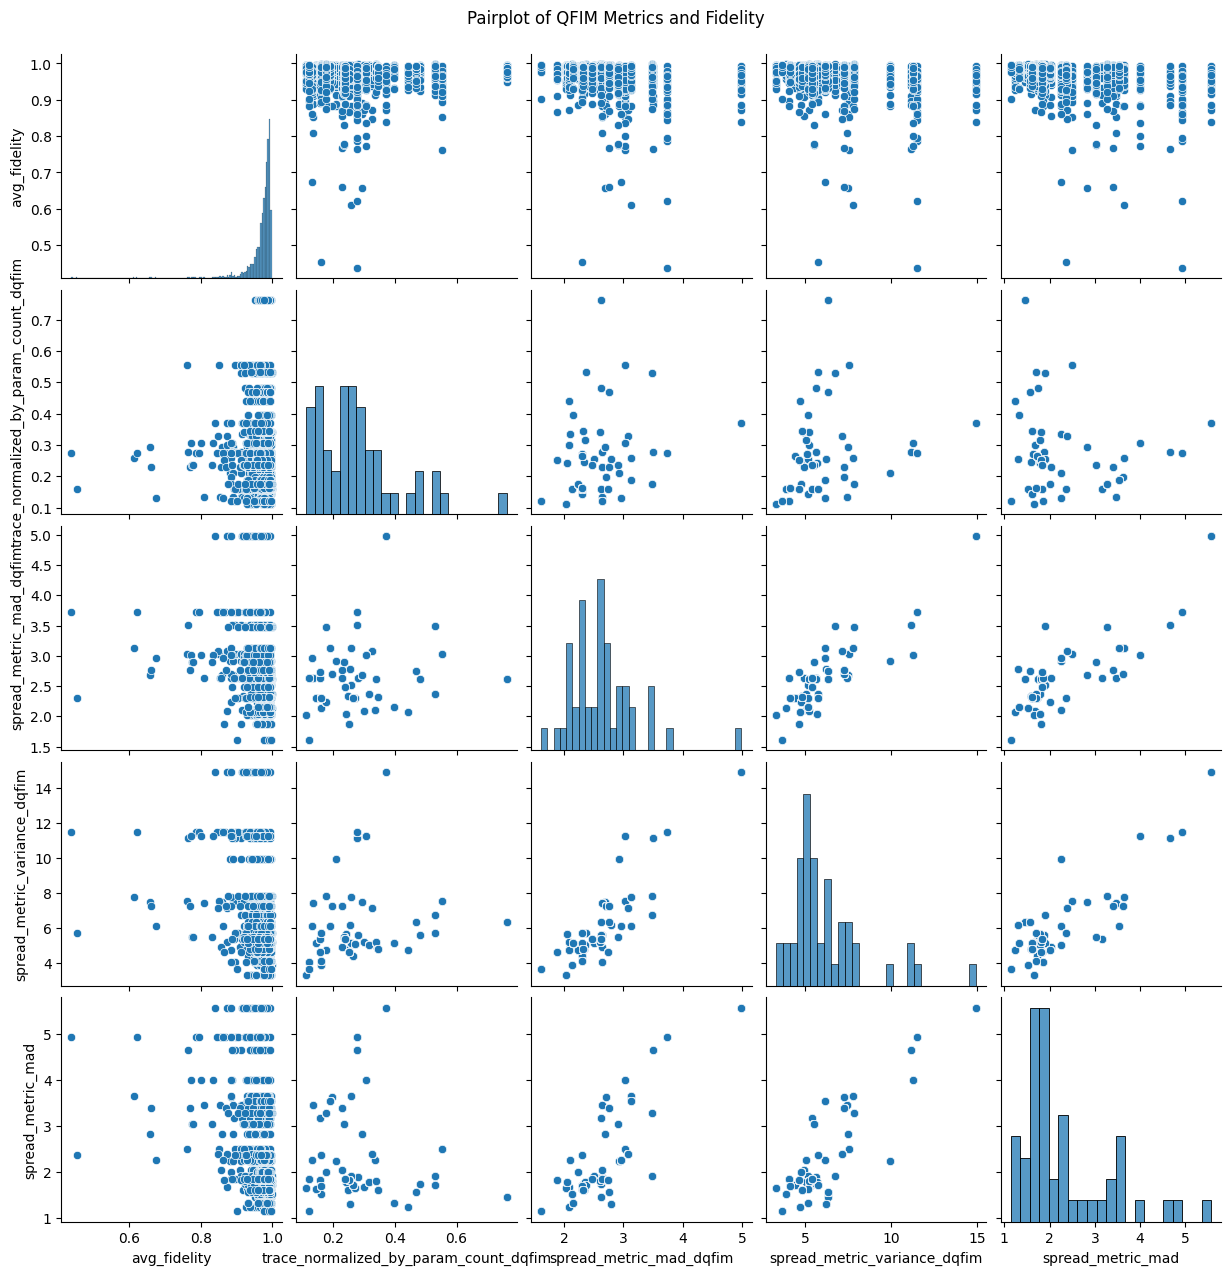

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# Define the list of columns (metrics) you wish to examine.
# Adjust these names if your columns have different names.
metrics_to_plot = [
    'avg_fidelity',         # Averaged fidelity from test results
    # 'trace_eigenvalues',                # Trace of QFIM
    'trace_normalized_by_param_count_dqfim',
    # 'ipr_deff_raw_dqfim',
   'spread_metric_mad_dqfim',  
    'spread_metric_variance_dqfim',
    # "var_nonzero_log",
    'spread_metric_mad',      
     
   

    # 'ipr_deff_raw_dqfim',  # Effective dimension computed via the paper's formula
   
]


# metrics_to_plot = [
#     'fidelity',         # Averaged fidelity from test results
#     'trace_dqfim',                # Trace of QFIM
#     # 'trace_normalized_by_param_count_dqfim',
#     # 'ipr_deff_raw_dqfim',
#    'spread_metric_variance_dqfim',  
#     'abbas_deff_raw_dqfim',
#     'spread_metric_mad_dqfim',      
     
   

#     # 'ipr_deff_raw_dqfim',  # Effective dimension computed via the paper's formula
   
# ]


# 2. Pair Plot
sns.pairplot(df_merged[metrics_to_plot])
plt.suptitle("Pairplot of QFIM Metrics and Fidelity", y=1.02)
plt.show()

In [63]:
import numpy as np
import numpy.ma as ma
#############################################
# Revised compute_single_draw_stats function #
#############################################
def compute_single_draw_stats(
    eigvals,
    full_qfim_mat,
    threshold=1e-10,
    spread_methods=("variance", "mad"),
    ddof=1,
    scale="normal",
    gamma=1.0,
    n=1,
    V_theta=1.0,
    n_ctrl=None,
    n_reserv=None,
    trotter_step=None,
):
    """
    Compute QFIM (or DQFIM) statistics for a SINGLE set of eigenvalues (one draw),
    and also compute an effective dimension from the provided full QFIM matrix.
    
    Returned dictionary includes:
      - "draw_rank"
      - "var_all_eigenvalues"
      - "var_nonzero_eigenvalues"
      - "trace_eigenvalues"
      - "var_all_normalized_by_param_count"
      - "trace_normalized_by_rank"
      - "var_nonzero_log"
      - "trace_normalized_by_param_count"
      - "ipr_deff_raw"        (raw IPR measure)
      - "ipr_deff_norm"       (IPR computed on trace-normalized eigenvalues)
      - "abbas_deff_raw"      (sum(log(1 + alpha*λ)) on raw eigenvalues)
      - "abbas_deff_norm"     (sum(log(1 + alpha*λ)) on trace-normalized eigenvalues)
      - "effective_dimension" (computed from the trace-normalized full QFIM)
      - "spread_metric_{method}" for each method in spread_methods.
    
    Parameters
    ----------
    eigvals : array-like
        Eigenvalues for this single QFIM (or DQFIM) draw.
    full_qfim_mat : array-like (2D)
        The full QFIM matrix for this draw.
    threshold : float
        Zero out eigenvalues below this threshold.
    spread_methods : tuple of str
        Methods for "spread-of-log" metrics.
    ddof : int
        Degrees of freedom for variance computations.
    scale : str
        Scale indicator for spread metrics.
    gamma : float
        Scaling parameter in the Abbas formula (typically in (0,1]).
    n : int
        Number of data samples used in the Abbas formula.
    V_theta : float
        Volume factor (typically 1.0).
    n_ctrl, n_reserv, trotter_step : optional
        Additional metadata.
    
    Returns
    -------
    stats_dict : dict
        Dictionary of computed statistics.
    """
    # Ensure eigvals is a 1D NumPy array.
    arr = np.array(eigvals, dtype=float)
    if arr.ndim != 1:
        arr = arr.flatten()
    # Zero out small eigenvalues.
    arr = np.where(arr < threshold, 0.0, arr)
    
    # --- 1) Basic stats ---
    draw_rank = np.count_nonzero(arr)
    var_all_eigenvalues = np.var(arr, ddof=ddof)
    # Variance on nonzero values using Boolean indexing.
    nonzero = arr[arr > threshold]
    var_nonzero_eigenvalues = np.var(nonzero, ddof=ddof) if nonzero.size > 1 else 0.0
    var_nonzero_log = np.log(var_nonzero_eigenvalues) if var_nonzero_eigenvalues > 0 else -np.inf
    trace_eigenvalues = np.sum(arr)
    
    var_normalized_by_param_count = var_all_eigenvalues / len(arr)
    var_nonzero_normalized_by_rank = var_nonzero_eigenvalues / draw_rank
    trace_normalized_by_rank = (trace_eigenvalues / draw_rank) if draw_rank > 0 else 0.0
    trace_normalized_by_param_count = trace_eigenvalues / len(arr)
    
    # --- 2) IPR-based dimensions ---
    # Raw IPR: (trace^2) / (sum of squares)
    sum_of_squares = np.sum(arr**2)
    ipr_deff_raw = (trace_eigenvalues**2) / sum_of_squares if sum_of_squares > 0 else 0.0
    
    # Normalized IPR: using normalized eigenvalues (p = λ/trace)
    if trace_eigenvalues > 0:
        arr_norm = arr / trace_eigenvalues
        sum_norm_sq = np.sum(arr_norm**2)
        ipr_deff_norm = 1.0 / sum_norm_sq if sum_norm_sq > 0 else 0.0
    else:
        arr_norm = None
        ipr_deff_norm = 0.0
    
    # --- 3) Abbas-based dimensions ---
    # Compute alpha = (gamma * n) / (2*log(n)) if n>1, else use limit.
    if n > 1 and math.log(n) != 0.0:
        alpha = (gamma * n) / (2.0 * math.log(n))
    else:
        alpha = 0.0
    # Raw Abbas: computed on original eigenvalues.
    abbas_deff_raw = np.sum(np.log(np.maximum(1.0 + alpha * arr, 1e-15)))
    # Normalized Abbas: computed on trace-normalized eigenvalues.
    if arr_norm is not None:
        abbas_deff_norm = np.sum(np.log(np.maximum(1.0 + alpha * arr_norm, 1e-15)))
    else:
        abbas_deff_norm = 0.0
    
    # --- 4) Effective dimension from the full QFIM ---
    # Normalize the full QFIM by its trace BEFORE diagonalizing.
    F = np.array(full_qfim_mat, dtype=float)
    trF = np.trace(F)
    if trF > 0:
        F_hat = F / trF
        eigs_F = np.linalg.eigvalsh(F_hat)  # Eigenvalues of the normalized full QFIM.
        eps = 1e-12
        # Here, effective dimension is computed from the normalized spectrum p_i.
        # If n > 1, use the standard formula; if n == 1, use the limit:
        if n > 1 and math.log(n) != 0.0:
            z = 0.5 * np.sum(np.log(1.0 + n * eigs_F + eps))
            effective_dimension = (2.0 / np.log(n)) * z
        else:
            # For n == 1, define effective dimension as the sum_i p_i/(1+p_i)
            effective_dimension = np.sum(eigs_F / (1.0 + eigs_F))
    else:
        effective_dimension = 0.0
    
    # --- 5) Spread-of-log metrics ---
    # Reshape arr into a 1-row 2D array for external functions.
    arr_2d = arr.reshape(1, -1)
    spread_metrics = {}
    for method in spread_methods:
        per_draw = spread_per_sample_vectorized(arr_2d, method=method, threshold=threshold, ddof=ddof, scale=scale)
        spread_metrics[f"spread_metric_{method}"] = per_draw[0] if per_draw.size > 0 else 0.0
    
    # --- 6) Build final dictionary ---
    stats_dict = {
        # Basic stats
        "draw_rank": draw_rank,
        "var_all_eigenvalues": var_all_eigenvalues,
        "var_nonzero_eigenvalues": var_nonzero_eigenvalues,
        "trace_eigenvalues": trace_eigenvalues,
        "var_all_normalized_by_param_count": var_normalized_by_param_count,
        "var_nonzero_normalized_by_rank":var_nonzero_normalized_by_rank,
        "trace_normalized_by_rank": trace_normalized_by_rank,
        "trace_normalized_by_param_count": trace_normalized_by_param_count,
        "var_nonzero_log": var_nonzero_log,
        
        # IPR-based dimensions
        "ipr_deff_raw": ipr_deff_raw,
        "ipr_deff_norm": ipr_deff_norm,
        
        # Abbas-based dimensions
        "abbas_deff_raw": abbas_deff_raw,
        "abbas_deff_norm": abbas_deff_norm,
        
        # Effective dimension computed from the full QFIM (trace-normalized)
        "d_eff": effective_dimension,
    }
    stats_dict.update(spread_metrics)
    
    return stats_dict

In [ ]:

def compute_single_draw_stats(
    eigvals,
    full_qfim_mat,
    threshold=1e-10,
    spread_methods=("variance", "mad"),
    ddof=1,
    scale="normal",
    # For Abbas dimension
    gamma=1.0,
    n=1,
    V_theta=1.0,
    n_ctrl=None,
    n_reserv=None,
    trotter_step=None,
):
    """
    Compute QFIM (or DQFIM) statistics for a SINGLE set of eigenvalues (one draw).

    This function mirrors the fields from compute_all_stats for a single-draw scenario.

    Returned dict includes:
      - "draw_rank"
      - "var_all_eigenvalues"
      - "var_nonzero_eigenvalues"
      - "trace_eigenvalues"
      - "var_normalized_by_rank"
      - "trace_normalized_by_rank"
      - "ipr_deff_raw"        (a "raw" dimension measure)
      - "ipr_deff_norm"       (a shape-based dimension measure)
      - "abbas_deff_raw"      (another "raw" dimension measure)
      - "abbas_deff_norm"     (another shape-based measure)
      - "spread_metric_{method}" for each method in spread_methods
         e.g. "spread_metric_variance", "spread_metric_mad"

    If you want to rename these keys to match precisely your multi-draw dictionary,
    you can do so by changing the dict keys below.

    Parameters
    ----------
    eigvals : array-like
        Eigenvalues for this single QFIM (or DQFIM) draw.
    threshold : float
        Zero out small eigenvalues below this threshold.
    spread_methods : tuple of str
        Methods for "spread-of-log" metrics. E.g. ("variance", "mad").
    ddof : int
        Degrees of freedom for variance computations.
    scale : str
        Scale for median_abs_deviation if using "mad".
    gamma : float
        In Abbas dimension formula, typically in (0, 1].
    n : int
        "Number of data samples" in that Abbas formula. If you only have a single set, you can set it = 1.
    V_theta : float
        Volume factor if you want to subtract log(V_theta). Typically 1.0 if unknown.

    Returns
    -------
    stats_dict : dict
        Dictionary of single-draw statistics as described.
    """
    import numpy as np

    # Make sure it's an array
    if isinstance(eigvals, (list, tuple)):
        arr = np.array(eigvals, dtype=float)
    elif isinstance(eigvals, np.ndarray):
        arr = eigvals.astype(float)
    else:
        arr = np.array(eigvals, dtype=float)

    arr = np.array(eigvals, dtype=float)
    if arr.ndim != 1:
        arr = arr.flatten()
    # Zero out small eigenvalues
    arr = np.where(arr < threshold, 0.0, arr)

    # --- 1) Basic stats ---
    draw_rank = np.count_nonzero(arr)
    var_all_eigenvalues = np.var(arr)
    # Nonzero subset
    nonzero = arr[arr > threshold]
    var_nonzero_eigenvalues = np.var(nonzero) if nonzero.size > 1 else 0.0
    var_nonzero_log = np.log(var_nonzero_eigenvalues)
    trace_eigenvalues = np.sum(arr)

    # rank-normalized

    var_normalized_by_param_count = var_all_eigenvalues / len(arr)
    var_nonzero_normalized_by_rank = var_nonzero_eigenvalues / draw_rank
    trace_normalized_by_rank = trace_eigenvalues / draw_rank
    trace_normalized_by_param_count = trace_eigenvalues / len(arr)


    # --- 2) IPR-based dimension measures ---
    sum_eigs_sq = np.sum(arr**2)

    # raw
    if sum_eigs_sq > 0.0:
        ipr_deff_raw = (trace_eigenvalues**2) / sum_eigs_sq
    else:
        ipr_deff_raw = 0.0

    # shape (normalized)
    if trace_eigenvalues > 0.0:
        arr_norm = arr / trace_eigenvalues
        sum_norm_sq = np.sum(arr_norm**2)
        ipr_deff_norm = 1.0 / sum_norm_sq if sum_norm_sq > 0 else 0.0
    else:
        arr_norm = None
        ipr_deff_norm = 0.0

    # --- 3) Abbas-based dimension measures ---
    # alpha = gamma * n / (2 * log(n)) if n>1
    import math
    if n > 1 and math.log(n) != 0.0:
        alpha = (gamma * n) / (2.0 * math.log(n))
    else:
        alpha = 0.0

    # raw
    abbas_deff_raw = 0.0
    for lam in arr:
        val = 1.0 + alpha * lam
        if val <= 0.0:
            val = 1e-15
        abbas_deff_raw += np.log(val)
    # if V_theta != 1.0: abbas_deff_raw -= np.log(V_theta)  # optional

    # normalized
    if arr_norm is not None:
        abbas_deff_norm = 0.0
        for lam_n in arr_norm:
            val = 1.0 + alpha * lam_n
            if val <= 0.0:
                val = 1e-15
            abbas_deff_norm += np.log(val)
        # if V_theta != 1.0: abbas_deff_norm -= np.log(V_theta)
    else:
        abbas_deff_norm = 0.0


    # Create a 1-row 2D array for convenience
    arr_2d = arr.reshape(1, -1)
    spread_metrics = {}
    for method in spread_methods:
        per_draw = spread_per_sample_vectorized(
            arr_2d,
            method=method,
            threshold=threshold,
            ddof=ddof,
            scale=scale
        )
        # there's exactly 1 value for a single row
        spread_metrics[f"spread_metric_{method}"] = per_draw[0] if per_draw.size > 0 else 0.0

    # --- 5) Build final dictionary ---
    stats_dict = {
        # Basic rank & absolute scale
        "draw_rank": draw_rank,
        "var_all_eigenvalues": var_all_eigenvalues,
        "var_nonzero_eigenvalues": var_nonzero_eigenvalues,
        "trace_eigenvalues": trace_eigenvalues,
        "var_all_normalized_by_param_count": var_normalized_by_param_count,
        "var_nonzero_normalized_by_rank":var_nonzero_normalized_by_rank,
        "var_nonzero_log":var_nonzero_log,
        "trace_normalized_by_rank": trace_normalized_by_rank,
        "trace_normalized_by_param_count": trace_normalized_by_param_count,
        

        # IPR dimension
        "ipr_deff_raw": ipr_deff_raw,
        "ipr_deff_norm": ipr_deff_norm,

        # Abbas dimension
        "abbas_deff_raw": abbas_deff_raw,
        "abbas_deff_norm": abbas_deff_norm,
    }
    stats_dict.update(spread_metrics)

    return stats_dict


In [39]:
df_results.keys()

Index(['costs', 'fidelity', 'num_params', 'test_results', 'qfim_eigvals',
       'qfim_full', 'entropy', 'N_ctrl', 'Trotter_Step', 'N_R', 'gate',
       'test_key', 'gate_folder', 'file_path'],
      dtype='object')

In [64]:
import numpy as np
import pandas as pd
def aggregate_results_list(df):
    """
    Aggregate the DataFrame by test_key.
    For each test key:
      - fidelities_list: a list of fidelity values (one per gate).
      - avg_fidelity: the mean fidelity (using the pandas mean).
      - error: aggregated error computed as the mean of log(1 - fidelity).
      - qfim_eigvals: taken from the first row.
      - entropy: extracted from the first row's qfim_stats.
    
    Returns a new DataFrame with one row per test key.
    """
    print(df.keys())
    aggregated = df.groupby("test_key").agg(
        fidelities_list=("fidelity", list),
        avg_fidelity=("fidelity", "mean"),
        error=("fidelity", lambda x: np.mean(np.log(1 - x))),
        qfim_eigvals=("qfim_eigvals", "first"),
        qfim_full=("qfim_full", "first"),
        entropy=("entropy", "first"),
        N_ctrl=("N_ctrl", "first"),
        N_reserv=("N_R", "first"),
        Trotter_Step=("Trotter_Step", "first")
    ).reset_index()
    
    return aggregated

df_agg = aggregate_results_list(df_results)
print("Aggregated DataFrame shape:", df_agg.shape)
# display(df_agg.head())

# Then update with QFIM metrics as before:
def update_with_qfim_metrics(df, threshold=1e-12, spread_methods=("variance", "mad"),
                             ddof=1, scale="normal", 
                             gamma=0.1, n=1, V_theta=1.0):
    """
    For each row in df (representing one test key), call compute_single_draw_stats 
    with the provided parameters.
    """
    new_rows = []
    for _, row in df.iterrows():
        eigvals = row["qfim_eigvals"]
        full_qfim_mat = row['qfim_full']
        qfim_metrics = compute_single_draw_stats(
            eigvals,
            full_qfim_mat,
            threshold=threshold,
            spread_methods=spread_methods,
            ddof=ddof,
            scale=scale,
            gamma=gamma,
            n=n,
            V_theta=V_theta,
            n_ctrl=row["N_ctrl"],
            n_reserv=row["N_reserv"],
            trotter_step=row["Trotter_Step"]
        )
        updated_row = row.to_dict()
        updated_row.update(qfim_metrics)
        new_rows.append(updated_row)
    return pd.DataFrame(new_rows)

df_final = update_with_qfim_metrics(df_agg)
# display(df_final.head())


Index(['costs', 'fidelity', 'num_params', 'test_results', 'qfim_eigvals',
       'qfim_full', 'entropy', 'N_ctrl', 'Trotter_Step', 'N_R', 'gate',
       'test_key', 'gate_folder', 'file_path'],
      dtype='object')
Aggregated DataFrame shape: (48, 10)


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_43056/3188202870.py:119: ComplexWarning:

Casting complex values to real discards the imaginary part



In [57]:
a = ['test184','test156','test79','test137','test52', 'test41', 'test96', 'test30', 'test69', 'test166', 'test151', 'test48', 'test40', 'test177', 'test98', 'test152', 'test132', 'test111', 'test5', 'test106', 'test65', 'test110', 'test45', 'test24', 'test163', 'test130', 'test171', 'test49', 'test8', 'test6', 'test136', 'test63', 'test145', 'test3', 'test36', 'test158', 'test86', 'test21', 'test80', 'test29', 'test56', 'test31', 'test157', 'test71', 'test0', 'test189', 'test181', 'test28']
'test184' in a
import math

In [65]:


def collect_dqfim_stats(all_tests_data, fixed_params_key, threshold=1e-12, gamma=1.0, n=100):
    """
    Build a single dictionary-of-dicts for the DQFIM stats keyed by test_key.

    Returns a dict:

        {
           test_key1: {
               "draw_rank": ...,
               "trace_eigenvalues": ...,
               "ipr_deff_raw_dqfim": ...,
               ... all metrics ...
           },
           test_key2: {...},
           ...
        }

    Then we can convert to a DataFrame and merge.
    """
    dqfim_stats_dict = {}
    test_data = all_tests_data[fixed_params_key]

    for test_key, results in test_data.items():
        qfi_eigvals = results["qfim_eigvals"]
        qfim_mat = results["qfim"]
        # call your single-draw function
        stats = compute_single_draw_stats(
            qfi_eigvals,
            qfim_mat,
            threshold=threshold,
            gamma=gamma,
            n=n,           # number of data-based states
        )
      
        # rename or store with distinct suffix (e.g. "_dqfim") if you want
        # so they don’t collide with existing columns
        dqfim_stats_dict[test_key] = {
            "draw_rank_dqfim": stats["draw_rank"],
            "trace_dqfim": stats["trace_eigenvalues"],
            "trace_normalized_by_rank_dqfim": stats["trace_normalized_by_rank"],
            "trace_normalized_by_param_count_dqfim": stats["trace_normalized_by_param_count"],
            "var_all_eigenvalues_dqfim": stats["var_all_eigenvalues"],
            "var_nonzero_eigenvalues_dqfim": stats["var_nonzero_eigenvalues"],
            "var_all_normalized_by_param_count_dqfim": stats["var_all_normalized_by_param_count"],
            "var_nonzero_normalized_by_rank_dqfim": stats["var_nonzero_normalized_by_rank"],
             "var_nonzero_log_dqfim": stats["var_nonzero_log"],
            "ipr_deff_raw_dqfim": stats["ipr_deff_raw"],
            "ipr_deff_norm_dqfim": stats["ipr_deff_norm"],
            "abbas_deff_raw_dqfim": stats["abbas_deff_raw"],
            "abbas_deff_norm_dqfim": stats["abbas_deff_norm"],
            # And the spread-of-log results:
            "spread_metric_variance_dqfim": stats.get("spread_metric_variance", 0.0),
            "spread_metric_mad_dqfim": stats.get("spread_metric_mad", 0.0),
            "d_eff_dqfim": stats.get("d_eff",0.0)
        }
    return dqfim_stats_dict

L = 20
T = 14
file_path = (
    f"/Users/sophieblock/QRCcapstone/parameter_analysis_directory/"
    f"QFIM_global_results/gate_model_DQFIM/Nc_2/sample_pi/1xK/"
    f"Nr_1/trotter_step_{T}/L_{L}/data.pickle"
)
print(file_path)
with open(file_path, 'rb') as f:
    all_tests_data = pickle.load(f)

fixed_params_key = "fixed_params0"
dqfim_stats_dict = collect_dqfim_stats(
    all_tests_data,
    fixed_params_key,
    threshold=1e-12,
    gamma=1.0,
    n=L
)


# Convert the dictionary-of-dicts to a DataFrame, keyed by test_key
df_dqfim = pd.DataFrame.from_dict(dqfim_stats_dict, orient="index")
df_dqfim.reset_index(inplace=True)
df_dqfim.rename(columns={"index": "test_key"}, inplace=True)

# Now df_dqfim has columns like:
#   test_key, trace_dqfim, var_all_eigenvalues_dqfim, ...
# Merge onto df_final on 'test_key'
df_merged = pd.merge(df_final, df_dqfim, on="test_key", how="left")

# print("df_merged columns:", df_merged.columns)








/Users/sophieblock/QRCcapstone/parameter_analysis_directory/QFIM_global_results/gate_model_DQFIM/Nc_2/sample_pi/1xK/Nr_1/trotter_step_14/L_20/data.pickle


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_43056/3188202870.py:119: ComplexWarning:

Casting complex values to real discards the imaginary part



In [66]:
import pingouin as pg
import warnings
x_metric = "avg_fidelity"
metrics_of_interest = [
    "entropy","var_all_eigenvalues", "var_nonzero_eigenvalues", "trace_eigenvalues",
    "var_nonzero_log", "var_nonzero_normalized_by_rank",
    "trace_normalized_by_rank",
    "ipr_deff_raw", "ipr_deff_norm",
    "spread_metric_variance", "spread_metric_mad",
    "trace_dqfim","trace_normalized_by_param_count_dqfim",
   "var_all_eigenvalues_dqfim","var_nonzero_log_dqfim",
    "var_nonzero_eigenvalues_dqfim", "var_all_normalized_by_param_count_dqfim",
    "var_nonzero_normalized_by_rank_dqfim", "ipr_deff_raw_dqfim",
    "ipr_deff_norm_dqfim", "abbas_deff_raw_dqfim", "abbas_deff_norm_dqfim",
    "spread_metric_variance_dqfim", "spread_metric_mad_dqfim",
    "d_eff", "d_eff_dqfim"
]

# Build a new DataFrame focusing on these columns plus 'fidelity' 
# (or 'avg_fidelity' if you only have aggregated fidelity).
df_corr = df_merged[[x_metric] + metrics_of_interest].copy()

df_corr = df_corr.dropna(subset=[x_metric] + metrics_of_interest)
print("Columns in df_corr:", df_corr.columns)
print("Number of rows after dropna:", len(df_corr))
# For each column that might contain JAX arrays:
# cols_to_fix = ["entropy"] + metrics_of_interest

# for c in cols_to_fix:
#     df_corr[c] = df_corr[c].apply(
#         lambda val: float(val.item()) if hasattr(val, "item") else float(val)
#     )
# 1) Pearson
pearson_results = {}
for col in metrics_of_interest:
    df_corr[col] = df_corr[col].apply(
        lambda val: float(val.item()) if hasattr(val, "item") else float(val)
    )
    res_df = pg.corr(x=df_corr[x_metric], y=df_corr[col], method="pearson")
    r_val = res_df["r"].iloc[0]
    p_val = res_df["p-val"].iloc[0]
    pearson_results[col] = {
        "pearson_r": r_val,
        "p_value": p_val
    }

# Print them out
# print("\nPairwise correlations vs. avg_fidelity (Pearson):")
# for k, v in pearson_results.items():
#     print(f"{k}: r={v['pearson_r']:.3f}, p={v['p_value']:.3g}")

# 2) Spearman
spearman_results = {}
for col in metrics_of_interest:
    sp_df = pg.corr(x=df_corr[x_metric], y=df_corr[col], method="spearman")
    rho_val = sp_df["r"].iloc[0]
    p_val = sp_df["p-val"].iloc[0]
    spearman_results[col] = {
        "spearman_rho": rho_val,
        "p_value": p_val
    }

# 3) Possibly filter by thresholds:
CORR_THRESHOLD = 0.2   
P_THRESHOLD    = 0.05 

print(f"\nPairwise correlations vs. {x_metric} (Pearson):")
for metric, vals in pearson_results.items():
    if abs(vals["pearson_r"]) > CORR_THRESHOLD and vals["p_value"] < P_THRESHOLD:
        print(f"{metric}: r={vals['pearson_r']:.3f}, p={vals['p_value']:.3g}")

print(f"\nPairwise correlations vs. {x_metric} (Spearman):")
for metric, vals in spearman_results.items():
    if abs(vals["spearman_rho"]) > CORR_THRESHOLD and vals["p_value"] < P_THRESHOLD:
        print(f"{metric}: rho={vals['spearman_rho']:.3f}, p={vals['p_value']:.3g}")

Columns in df_corr: Index(['avg_fidelity', 'entropy', 'var_all_eigenvalues',
       'var_nonzero_eigenvalues', 'trace_eigenvalues', 'var_nonzero_log',
       'var_nonzero_normalized_by_rank', 'trace_normalized_by_rank',
       'ipr_deff_raw', 'ipr_deff_norm', 'spread_metric_variance',
       'spread_metric_mad', 'trace_dqfim',
       'trace_normalized_by_param_count_dqfim', 'var_all_eigenvalues_dqfim',
       'var_nonzero_log_dqfim', 'var_nonzero_eigenvalues_dqfim',
       'var_all_normalized_by_param_count_dqfim',
       'var_nonzero_normalized_by_rank_dqfim', 'ipr_deff_raw_dqfim',
       'ipr_deff_norm_dqfim', 'abbas_deff_raw_dqfim', 'abbas_deff_norm_dqfim',
       'spread_metric_variance_dqfim', 'spread_metric_mad_dqfim', 'd_eff',
       'd_eff_dqfim'],
      dtype='object')
Number of rows after dropna: 48

Pairwise correlations vs. avg_fidelity (Pearson):
var_all_eigenvalues: r=-0.382, p=0.00746
var_nonzero_eigenvalues: r=-0.364, p=0.0109
trace_eigenvalues: r=-0.536, p=8.78e-05
var

In [51]:
import pingouin as pg
import warnings
x_metric = "avg_fidelity"
metrics_of_interest = [
    "entropy","var_all_eigenvalues", "var_nonzero_eigenvalues", "trace_eigenvalues",
    "var_nonzero_log", "var_nonzero_normalized_by_rank",
    "trace_normalized_by_rank",
    "ipr_deff_raw", "ipr_deff_norm",
    "spread_metric_variance", "spread_metric_mad",
    "trace_dqfim","trace_normalized_by_param_count_dqfim",
   "var_all_eigenvalues_dqfim","var_nonzero_log_dqfim",
    "var_nonzero_eigenvalues_dqfim", "var_all_normalized_by_param_count_dqfim",
    "var_nonzero_normalized_by_rank_dqfim", "ipr_deff_raw_dqfim",
    "ipr_deff_norm_dqfim", "abbas_deff_raw_dqfim", "abbas_deff_norm_dqfim",
    "spread_metric_variance_dqfim", "spread_metric_mad_dqfim"
]

# Build a new DataFrame focusing on these columns plus 'fidelity' 
# (or 'avg_fidelity' if you only have aggregated fidelity).
df_corr = df_merged[[x_metric] + metrics_of_interest].copy()

df_corr = df_corr.dropna(subset=[x_metric] + metrics_of_interest)
print("Columns in df_corr:", df_corr.columns)
print("Number of rows after dropna:", len(df_corr))
# For each column that might contain JAX arrays:
# cols_to_fix = ["entropy"] + metrics_of_interest

# for c in cols_to_fix:
#     df_corr[c] = df_corr[c].apply(
#         lambda val: float(val.item()) if hasattr(val, "item") else float(val)
#     )
# 1) Pearson
pearson_results = {}
for col in metrics_of_interest:
    df_corr[col] = df_corr[col].apply(
        lambda val: float(val.item()) if hasattr(val, "item") else float(val)
    )
    res_df = pg.corr(x=df_corr[x_metric], y=df_corr[col], method="pearson")
    r_val = res_df["r"].iloc[0]
    p_val = res_df["p-val"].iloc[0]
    pearson_results[col] = {
        "pearson_r": r_val,
        "p_value": p_val
    }

# Print them out
# print("\nPairwise correlations vs. avg_fidelity (Pearson):")
# for k, v in pearson_results.items():
#     print(f"{k}: r={v['pearson_r']:.3f}, p={v['p_value']:.3g}")

# 2) Spearman
spearman_results = {}
for col in metrics_of_interest:
    sp_df = pg.corr(x=df_corr[x_metric], y=df_corr[col], method="spearman")
    rho_val = sp_df["r"].iloc[0]
    p_val = sp_df["p-val"].iloc[0]
    spearman_results[col] = {
        "spearman_rho": rho_val,
        "p_value": p_val
    }

# 3) Possibly filter by thresholds:
CORR_THRESHOLD = 0.2   
P_THRESHOLD    = 0.05 

print(f"\nPairwise correlations vs. {x_metric} (Pearson):")
for metric, vals in pearson_results.items():
    if abs(vals["pearson_r"]) > CORR_THRESHOLD and vals["p_value"] < P_THRESHOLD:
        print(f"{metric}: r={vals['pearson_r']:.3f}, p={vals['p_value']:.3g}")

print(f"\nPairwise correlations vs. {x_metric} (Spearman):")
for metric, vals in spearman_results.items():
    if abs(vals["spearman_rho"]) > CORR_THRESHOLD and vals["p_value"] < P_THRESHOLD:
        print(f"{metric}: rho={vals['spearman_rho']:.3f}, p={vals['p_value']:.3g}")

Columns in df_corr: Index(['avg_fidelity', 'entropy', 'var_all_eigenvalues',
       'var_nonzero_eigenvalues', 'trace_eigenvalues', 'var_nonzero_log',
       'var_nonzero_normalized_by_rank', 'trace_normalized_by_rank',
       'ipr_deff_raw', 'ipr_deff_norm', 'spread_metric_variance',
       'spread_metric_mad', 'trace_dqfim',
       'trace_normalized_by_param_count_dqfim', 'var_all_eigenvalues_dqfim',
       'var_nonzero_log_dqfim', 'var_nonzero_eigenvalues_dqfim',
       'var_all_normalized_by_param_count_dqfim',
       'var_nonzero_normalized_by_rank_dqfim', 'ipr_deff_raw_dqfim',
       'ipr_deff_norm_dqfim', 'abbas_deff_raw_dqfim', 'abbas_deff_norm_dqfim',
       'spread_metric_variance_dqfim', 'spread_metric_mad_dqfim'],
      dtype='object')
Number of rows after dropna: 48

Pairwise correlations vs. avg_fidelity (Pearson):
var_all_eigenvalues: r=-0.382, p=0.00746
var_nonzero_eigenvalues: r=-0.364, p=0.0109
trace_eigenvalues: r=-0.536, p=8.78e-05
var_nonzero_log: r=-0.323, p=0.025

In [69]:
import plotly.express as px
predictor_metrics = [
    
    # 'trace_normalized_by_rank',
    'error',
    'var_nonzero_normalized_by_rank',
    
    'trace_normalized_by_rank',
    'd_eff'
    # 'spread_metric_variance',
    # 'spread_metric_mad',
    # 'spread_metric_variance_dqfim',
    # "spread_metric_variance_dqfim"
    # "trace_normalized_by_rank"
    # 'spread_metric_variance_dqfim',
    # "abbas_deff_raw_dqfim",
    # "ipr_deff_raw_dqfim"}
]
metrics_to_visualize = [
    "test_key",
    'avg_fidelity',
    'error',
    'trace_eigenvalues',
    'trace_normalized_by_rank',
    'var_nonzero_normalized_by_rank',
    'var_nonzero_log',
    'var_nonzero_normalized_by_rank_dqfim',
    'spread_metric_mad',
    'spread_metric_variance',
    'spread_metric_variance_dqfim',
    "spread_metric_mad_dqfim",
    "abbas_deff_raw_dqfim",
    "abbas_deff_norm_dqfim",
    "d_eff",
    "d_eff_dqfim"
]

df_viz = df_merged[metrics_to_visualize].dropna()

fig = px.scatter_matrix(
    df_viz,
    dimensions=predictor_metrics,
    color="avg_fidelity",        # Use fidelity as the color dimension
    hover_data=["test_key"],      # Show test_key on hover
    title="Scatter Matrix of Predictors with Fidelity as Color"
)
fig.update_layout(width=1000, height=1000)
fig.show()

In [65]:
import plotly.express as px
predictor_metrics = [
    
    # 'trace_normalized_by_rank',
    'error',
    'var_all_eigenvalues',
    
    # 'spread_metric_variance_dqfim',
    'trace_normalized_by_rank',
    # "spread_metric_mad_dqfim"
    # 'spread_metric_variance_dqfim',
    "spread_metric_mad"
]
metrics_to_visualize = [
    "test_key",
    'avg_fidelity',
    'var_all_eigenvalues',
    'var_nonzero_eigenvalues',
    'error',
    'trace_normalized_by_rank',
    'var_nonzero_log',
    'spread_metric_mad',
    'spread_metric_variance',
    'spread_metric_variance_dqfim',
    "spread_metric_mad_dqfim",
    "abbas_deff_raw_dqfim"
]

df_viz = df_merged[metrics_to_visualize].dropna()

fig = px.scatter_matrix(
    df_viz,
    dimensions=predictor_metrics,
    color="avg_fidelity",        # Use fidelity as the color dimension
    hover_data=["test_key"],      # Show test_key on hover
    title="Scatter Matrix of Predictors with Fidelity as Color"
)
fig.update_layout(width=1000, height=1000)
fig.show()

In [23]:
# import plotly.express as px

# fig = px.scatter_matrix(df_viz,
#                         dimensions=metrics_to_visualize,
#                         title="Scatter Matrix of Selected Metrics")
# fig.update_layout(width=1200, height=1200)
# fig.show()

In [303]:
import pingouin as pg
import warnings
x_metric = "avg_fidelity"


# Build a new DataFrame focusing on these columns plus 'fidelity' 
# (or 'avg_fidelity' if you only have aggregated fidelity).
df_corr = df_merged[[x_metric] + metrics_of_interest].copy()

df_corr = df_corr.dropna(subset=[x_metric] + metrics_of_interest)
print("Columns in df_corr:", df_corr.columns)
print("Number of rows after dropna:", len(df_corr))
# For each column that might contain JAX arrays:
# cols_to_fix = ["entropy"] + metrics_of_interest

# for c in cols_to_fix:
#     df_corr[c] = df_corr[c].apply(
#         lambda val: float(val.item()) if hasattr(val, "item") else float(val)
#     )
# 1) Pearson
pearson_results = {}
for col in metrics_of_interest:
    df_corr[col] = df_corr[col].apply(
        lambda val: float(val.item()) if hasattr(val, "item") else float(val)
    )
    res_df = pg.corr(x=df_corr[x_metric], y=df_corr[col], method="pearson")
    r_val = res_df["r"].iloc[0]
    p_val = res_df["p-val"].iloc[0]
    pearson_results[col] = {
        "pearson_r": r_val,
        "p_value": p_val
    }

# Print them out
# print("\nPairwise correlations vs. avg_fidelity (Pearson):")
# for k, v in pearson_results.items():
#     print(f"{k}: r={v['pearson_r']:.3f}, p={v['p_value']:.3g}")

# 2) Spearman
spearman_results = {}
for col in metrics_of_interest:
    sp_df = pg.corr(x=df_corr[x_metric], y=df_corr[col], method="spearman")
    rho_val = sp_df["r"].iloc[0]
    p_val = sp_df["p-val"].iloc[0]
    spearman_results[col] = {
        "spearman_rho": rho_val,
        "p_value": p_val
    }

# 3) Possibly filter by thresholds:
CORR_THRESHOLD = 0.2   
P_THRESHOLD    = 0.05

print(f"\nPairwise correlations vs. {x_metric} (Pearson):")
for metric, vals in pearson_results.items():
    if abs(vals["pearson_r"]) > CORR_THRESHOLD and vals["p_value"] < P_THRESHOLD:
        print(f"{metric}: r={vals['pearson_r']:.3f}, p={vals['p_value']:.3g}")

print(f"\nPairwise correlations vs. {x_metric} (Spearman):")
for metric, vals in spearman_results.items():
    if abs(vals["spearman_rho"]) > CORR_THRESHOLD and vals["p_value"] < P_THRESHOLD:
        print(f"{metric}: rho={vals['spearman_rho']:.3f}, p={vals['p_value']:.3g}")

Columns in df_corr: Index(['avg_fidelity', 'entropy', 'var_all_eigenvalues',
       'var_nonzero_eigenvalues', 'trace_eigenvalues', 'var_nonzero_log',
       'var_nonzero_normalized_by_rank', 'trace_normalized_by_rank',
       'ipr_deff_raw', 'ipr_deff_norm', 'spread_metric_variance',
       'spread_metric_mad', 'trace_dqfim',
       'trace_normalized_by_param_count_dqfim', 'var_all_eigenvalues_dqfim',
       'var_nonzero_log_dqfim', 'var_nonzero_eigenvalues_dqfim',
       'var_all_normalized_by_param_count_dqfim',
       'var_nonzero_normalized_by_rank_dqfim', 'ipr_deff_raw_dqfim',
       'ipr_deff_norm_dqfim', 'abbas_deff_raw_dqfim', 'abbas_deff_norm_dqfim',
       'spread_metric_variance_dqfim', 'spread_metric_mad_dqfim'],
      dtype='object')
Number of rows after dropna: 44

Pairwise correlations vs. avg_fidelity (Pearson):
var_all_eigenvalues: r=-0.379, p=0.0111
var_nonzero_eigenvalues: r=-0.362, p=0.0158
trace_eigenvalues: r=-0.536, p=0.000174
var_nonzero_log: r=-0.303, p=0.0458

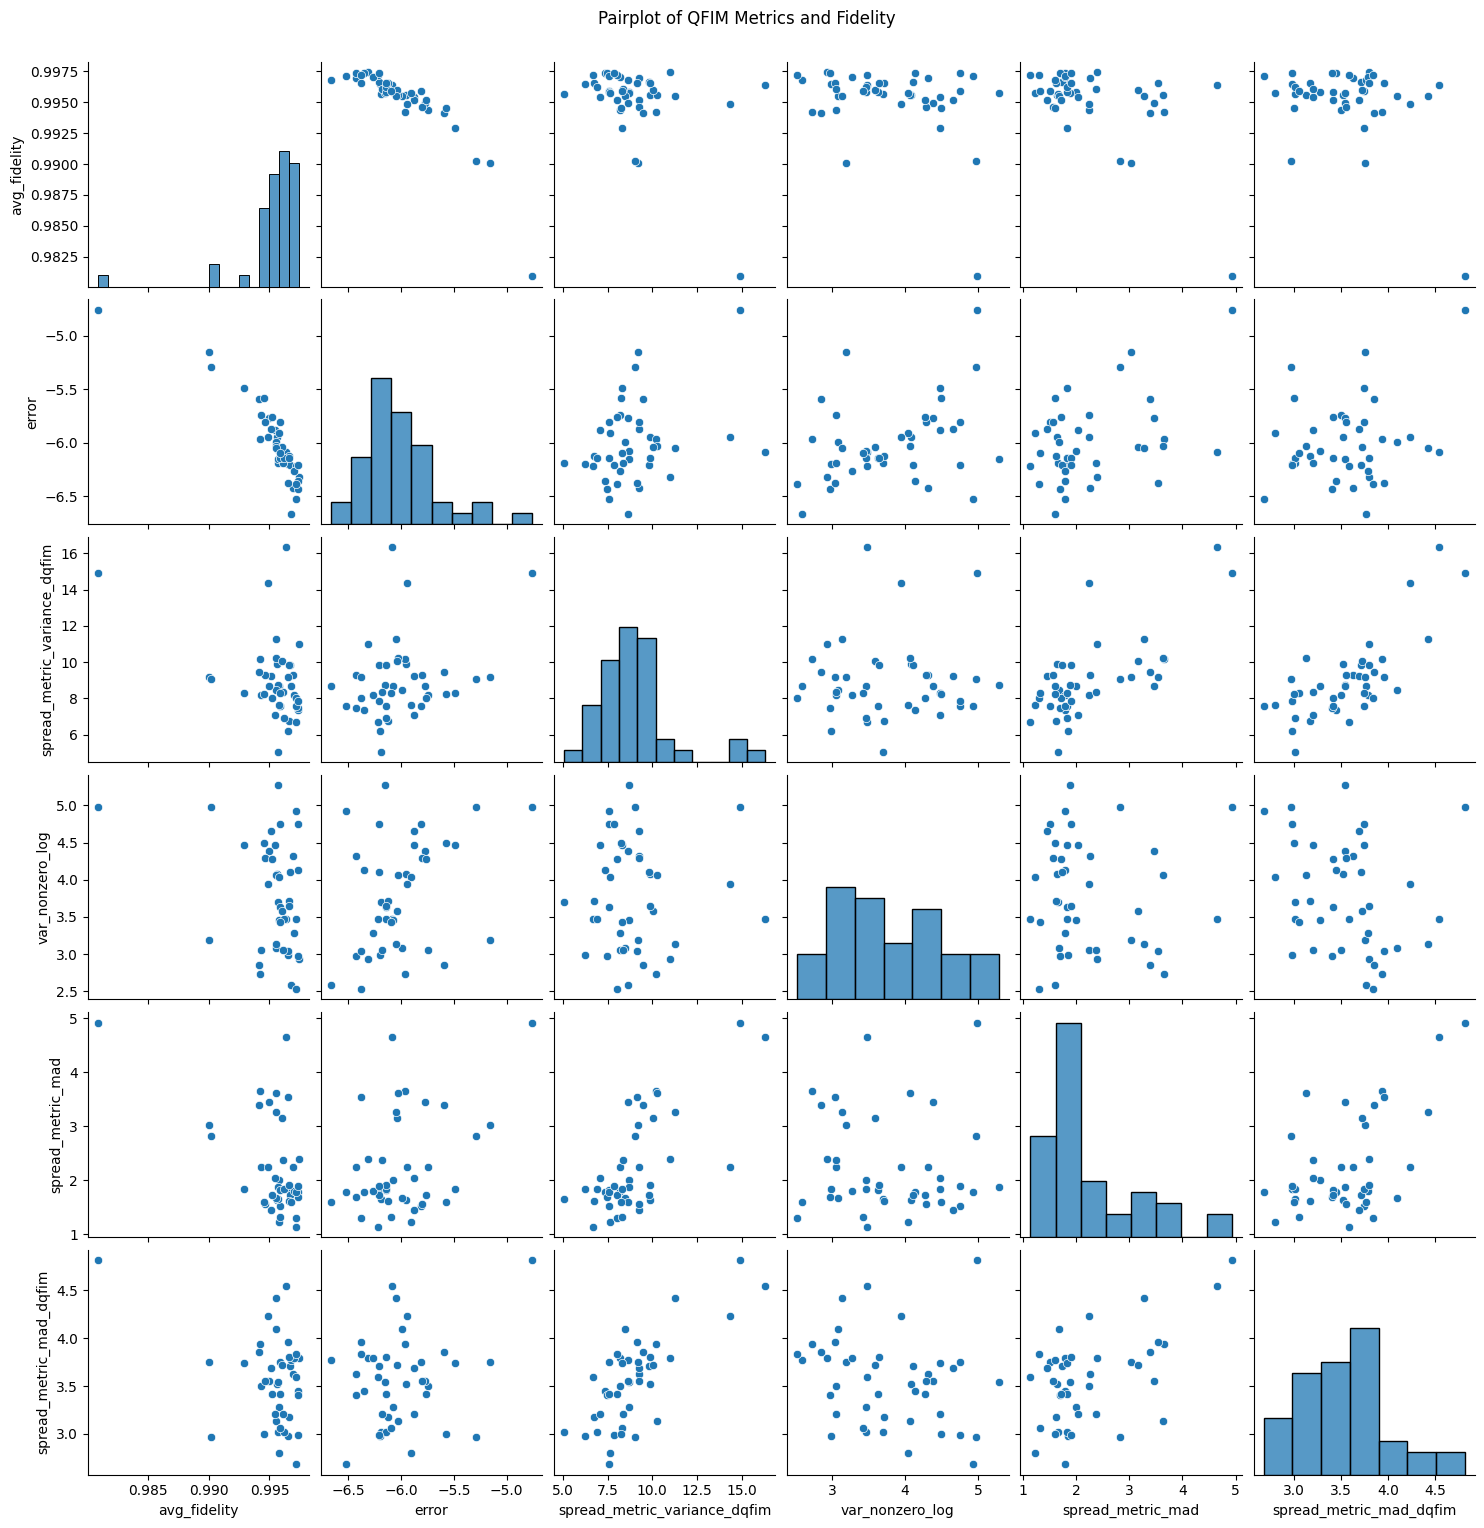

In [291]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# Define the list of columns (metrics) you wish to examine.
# Adjust these names if your columns have different names.
metrics_to_plot = [
    'avg_fidelity',         # Averaged fidelity from test results
    "error",
    'spread_metric_variance_dqfim',                # Trace of QFIM
    'var_nonzero_log',
    # 'ipr_deff_raw_dqfim',
   'spread_metric_mad',  
    # 'abbas_deff_raw_dqfim',
    'spread_metric_mad_dqfim',      
     
   

    # 'ipr_deff_raw_dqfim',  # Effective dimension computed via the paper's formula
   
]


# 2. Pair Plot
sns.pairplot(df_merged[metrics_to_plot])
plt.suptitle("Pairplot of QFIM Metrics and Fidelity", y=1.02)
plt.show()

In [264]:

import pingouin as pg
import warnings
# Suppose you have:
metrics_of_interest = [
    "entropy", "var_all_eigenvalues", "var_nonzero_eigenvalues", "trace_eigenvalues",
    "var_all_normalized_by_param_count", "var_nonzero_normalized_by_rank",
    "trace_normalized_by_rank", "trace_normalized_by_param_count",
    "ipr_deff_raw", "ipr_deff_norm",
    "spread_metric_variance", "spread_metric_mad",
    "trace_dqfim", "trace_normalized_by_rank_dqfim",
    "trace_normalized_by_param_count_dqfim", "var_all_eigenvalues_dqfim",
    "var_nonzero_eigenvalues_dqfim", "var_all_normalized_by_param_count_dqfim",
    "var_nonzero_normalized_by_rank_dqfim", "ipr_deff_raw_dqfim",
    "ipr_deff_norm_dqfim", "abbas_deff_raw_dqfim", "abbas_deff_norm_dqfim",
    "spread_metric_variance_dqfim", "spread_metric_mad_dqfim"
]

# Build a new DataFrame focusing on these columns plus `avg_fidelity`.
df_corr = df_merged[["avg_fidelity"] + metrics_of_interest].copy()
df_corr = df_corr.dropna(subset=["avg_fidelity"] + metrics_of_interest)
print("Columns in df_corr:", df_corr.columns)
print("Number of rows after dropna:", len(df_corr))

# -----------------------------------------
# 1) Calculate Pearson correlations
# -----------------------------------------
pearson_results = {}
for col in metrics_of_interest:
    # The pingouin.corr(...) function returns a small dataframe with columns:
    # ['n', 'r', 'CI95%', 'p-val', 'BF10', 'power']
    # We’re interested in the “r” (Pearson’s r) and “p-val”
    res_df = pg.corr(x=df_corr["avg_fidelity"], y=df_corr[col], method="pearson")
    r_val = res_df["r"].iloc[0]
    p_val = res_df["p-val"].iloc[0]
    
    pearson_results[col] = {
        "pearson_r": r_val,
        "p_value": p_val
    }

# Print them out
# print("Pairwise correlations vs. avg_fidelity (Pearson):")
# for k, v in pearson_results.items():
#     print(f"{k}: r={v['pearson_r']:.3f}, p={v['p_value']:.3g}")

# -----------------------------------------
# 2) Calculate Spearman correlations
# -----------------------------------------
spearman_results = {}
for col in metrics_of_interest:
    sp_df = pg.corr(x=df_corr["avg_fidelity"], y=df_corr[col], method="spearman")
    rho_val = sp_df["r"].iloc[0]       # Spearman's rho
    p_val = sp_df["p-val"].iloc[0]
    
    spearman_results[col] = {
        "spearman_rho": rho_val,
        "p_value": p_val
    }

# print("\nPairwise correlations vs. avg_fidelity (Spearman):")
# for k, v in spearman_results.items():
#     print(f"{k}: rho={v['spearman_rho']:.3f}, p={v['p_value']:.3g}")

# -----------------------------------------
# 3) Filter which metrics pass your thresholds
# -----------------------------------------
# For example, define:
#    - correlation magnitude must be > 0.2 (i.e. at least "weak" to moderate/strong)
#    - p-value < 0.05 for significance
# You can do this for either Pearson or Spearman or both.

selected_metrics_pearson = []
selected_metrics_spearman = []

CORR_THRESHOLD = 0.2   # i.e. "weak or stronger"
P_THRESHOLD    = 0.05  # typical cutoff for 'significant'
print("\nPairwise correlations vs. avg_fidelity (Pearson):")
for metric, vals in pearson_results.items():
    if abs(vals["pearson_r"]) > CORR_THRESHOLD and vals["p_value"] < P_THRESHOLD:
        selected_metrics_pearson.append(metric)
        print(f"{metric}: r={vals['pearson_r']:.3f}, p={vals['p_value']:.3g}")

print("\nPairwise correlations vs. avg_fidelity (Spearman):")
for metric, vals in spearman_results.items():
    if abs(vals["spearman_rho"]) > CORR_THRESHOLD and vals["p_value"] < P_THRESHOLD:
        selected_metrics_spearman.append(metric)
        
        print(f"{metric}: rho={vals['spearman_rho']:.3f}, p={vals['p_value']:.3g}")

# print("\nMetrics with Pearson correlation > 0.2 (in magnitude) and p < 0.05:")
# print(selected_metrics_pearson)

# print("\nMetrics with Spearman correlation > 0.2 (in magnitude) and p < 0.05:")
# print(selected_metrics_spearman)

# # Check which metrics raise a warning
# print("Checking for warnings during Pearson correlation computation:")
# for col in metrics_of_interest:
#     with warnings.catch_warnings(record=True) as w:
#         warnings.simplefilter("always")
#         res_df = pg.corr(x=df_corr["avg_fidelity"], y=df_corr[col], method="pearson")
#         if w:
#             print(f"Metric {col} raised a warning: {w[0].message}")

Columns in df_corr: Index(['avg_fidelity', 'entropy', 'var_all_eigenvalues',
       'var_nonzero_eigenvalues', 'trace_eigenvalues',
       'var_all_normalized_by_param_count', 'var_nonzero_normalized_by_rank',
       'trace_normalized_by_rank', 'trace_normalized_by_param_count',
       'ipr_deff_raw', 'ipr_deff_norm', 'spread_metric_variance',
       'spread_metric_mad', 'trace_dqfim', 'trace_normalized_by_rank_dqfim',
       'trace_normalized_by_param_count_dqfim', 'var_all_eigenvalues_dqfim',
       'var_nonzero_eigenvalues_dqfim',
       'var_all_normalized_by_param_count_dqfim',
       'var_nonzero_normalized_by_rank_dqfim', 'ipr_deff_raw_dqfim',
       'ipr_deff_norm_dqfim', 'abbas_deff_raw_dqfim', 'abbas_deff_norm_dqfim',
       'spread_metric_variance_dqfim', 'spread_metric_mad_dqfim'],
      dtype='object')
Number of rows after dropna: 44

Pairwise correlations vs. avg_fidelity (Pearson):
var_all_eigenvalues: r=-0.379, p=0.0111
var_nonzero_eigenvalues: r=-0.362, p=0.0158
trace_

In [292]:
import statsmodels.formula.api as smf

# Suppose your df_corr DataFrame has columns:
# "avg_fidelity", "metricA", "metricB", ...
# We'll do a simple linear model: avg_fidelity ~ metricA + metricB
model = smf.ols("avg_fidelity ~ trace_normalized_by_rank + spread_metric_variance_dqfim", data=df_corr)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           avg_fidelity   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     15.07
Date:                Tue, 11 Mar 2025   Prob (F-statistic):           1.24e-05
Time:                        15:26:43   Log-Likelihood:                 210.01
No. Observations:                  44   AIC:                            -414.0
Df Residuals:                      41   BIC:                            -408.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [293]:
import statsmodels.formula.api as smf

# Suppose your df_corr DataFrame has columns:
# "avg_fidelity", "metricA", "metricB", ...
# We'll do a simple linear model: avg_fidelity ~ metricA + metricB
model = smf.ols("avg_fidelity ~ trace_normalized_by_rank + spread_metric_mad_dqfim", data=df_corr)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           avg_fidelity   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     16.73
Date:                Tue, 11 Mar 2025   Prob (F-statistic):           4.88e-06
Time:                        15:26:56   Log-Likelihood:                 211.01
No. Observations:                  44   AIC:                            -416.0
Df Residuals:                      41   BIC:                            -410.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [195]:
# df_final[df_final['test_key','absolute_scale_trace_dqfim','trace_normalized_by_param_count_dqfim', 'trace_normalized_by_rank_dqfim']].head()

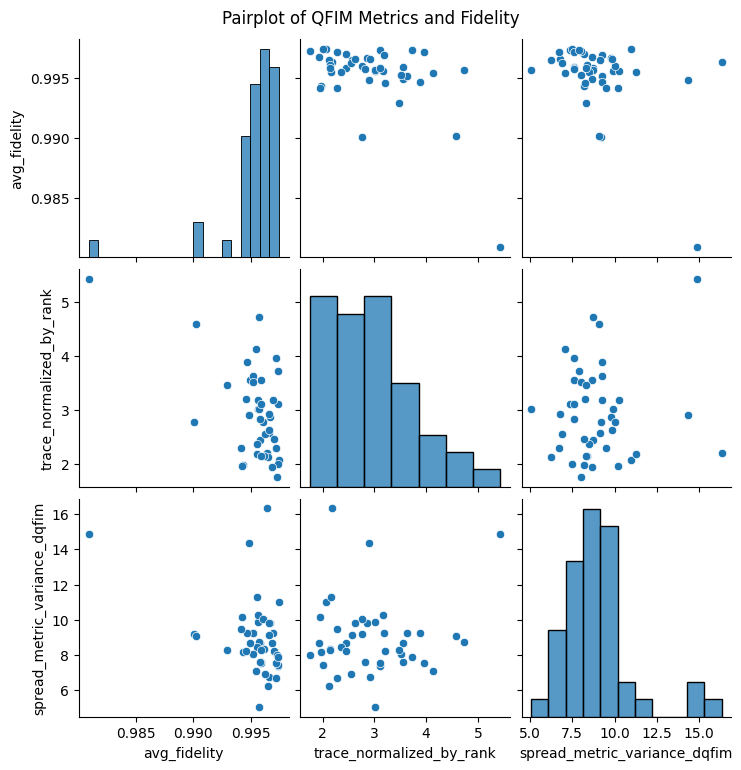

In [223]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# Define the list of columns (metrics) you wish to examine.
# Adjust these names if your columns have different names.
metrics_to_plot = [
    'avg_fidelity',         # Averaged fidelity from test results
    'trace_normalized_by_rank',                # Trace of QFIM
    # 'trace_normalized_by_param_count_dqfim',
    # 'ipr_deff_raw_dqfim',
   'spread_metric_variance_dqfim',  
    # 'abbas_deff_raw_dqfim',
    # 'spread_metric_mad_dqfim',      
     
   

    # 'ipr_deff_raw_dqfim',  # Effective dimension computed via the paper's formula
   
]


# 2. Pair Plot
sns.pairplot(df_merged[metrics_to_plot])
plt.suptitle("Pairplot of QFIM Metrics and Fidelity", y=1.02)
plt.show()

In [119]:
# Get the index of the row with the maximum value
max_idx = df_merged["spread_metric_variance_dqfim"].idxmax()

# Extract that row
max_row = df_merged.loc[max_idx]

# Show the test key and the value
print("Test key with the maximum 'spread_metric_variance_dqfim':", max_row["test_key"])
print("Maximum 'spread_metric_variance_dqfim' value:", max_row["spread_metric_variance_dqfim"])


Test key with the maximum 'spread_metric_variance_dqfim': test5
Maximum 'spread_metric_variance_dqfim' value: 14.884593655436046


In [7]:
import pingouin as pg
import statsmodels.api as sm
# Step 1: Explode the fidelities_list so each row has a single float "fidelity"
df_exploded = df_final.copy()
df_exploded = df_exploded.explode('fidelities_list')
# Rename fidelities_list -> fidelity (a single float per row)
df_exploded.rename(columns={'fidelities_list': 'fidelity'}, inplace=True)


df_exploded['fidelity'] = pd.to_numeric(df_exploded['fidelity'], errors='coerce')
print(df_exploded[['absolute_scale_trace', 'absolute_scale_var_nonzero', 'fidelity']].dtypes)
# 2) Drop rows that have NaN in these columns
df_exploded = df_exploded.dropna(subset=['absolute_scale_trace', 'absolute_scale_var_nonzero', 'fidelity'])

display(df_exploded.head())


absolute_scale_trace          float64
absolute_scale_var_nonzero    float64
fidelity                      float64
dtype: object


,test_key,fidelity,avg_fidelity,qfim_eigvals,entropy,draw_rank,absolute_scale_var_all,absolute_scale_var_nonzero,absolute_scale_trace,ipr_deff_raw,abbas_deff_raw,spectrum_shape_ipr_norm,spectrum_shape_abbas_norm,spread_metric_variance,spread_metric_mad,avg_per_active_mode_var_rank,avg_per_active_mode_trace_rank
0,test0,0.836711,0.858459,"[-4.896861e-16, -4.033972e-17, 1.7733267e-17, ...",0.449057,15,7.17733,8.665357,21.335633,2.839244,0.0,2.839244,0.0,24.864079,2.170404,0.478489,1.422376
0,test0,0.691378,0.858459,"[-4.896861e-16, -4.033972e-17, 1.7733267e-17, ...",0.449057,15,7.17733,8.665357,21.335633,2.839244,0.0,2.839244,0.0,24.864079,2.170404,0.478489,1.422376
0,test0,0.888481,0.858459,"[-4.896861e-16, -4.033972e-17, 1.7733267e-17, ...",0.449057,15,7.17733,8.665357,21.335633,2.839244,0.0,2.839244,0.0,24.864079,2.170404,0.478489,1.422376
0,test0,0.869274,0.858459,"[-4.896861e-16, -4.033972e-17, 1.7733267e-17, ...",0.449057,15,7.17733,8.665357,21.335633,2.839244,0.0,2.839244,0.0,24.864079,2.170404,0.478489,1.422376
0,test0,0.795661,0.858459,"[-4.896861e-16, -4.033972e-17, 1.7733267e-17, ...",0.449057,15,7.17733,8.665357,21.335633,2.839244,0.0,2.839244,0.0,24.864079,2.170404,0.478489,1.422376


In [8]:
cols_needed = [
    "absolute_scale_trace",         # or whatever name compute_single_draw_stats uses
    "absolute_scale_var_nonzero",
    "absolute_scale_var_all",
    "entropy",
    "ipr_deff_raw",
    "spectrum_shape_ipr_norm",
    "abbas_deff_raw",
    "spectrum_shape_abbas_norm",

     'spread_metric_variance', 'spread_metric_mad',
    "avg_fidelity"               # or "fidelity" if you plan to correlate the single-run fidelity
]

print("Columns present:", df_final.columns.tolist())

# Which columns are missing?
missing_cols = [c for c in cols_needed if c not in df_final.columns]
print("Missing columns:", missing_cols)

# Show dtypes of needed columns
print("\nColumn dtypes:")
print(df_final[cols_needed].dtypes)

# Look at the first few rows
print("\nSample rows:")
print(df_final[cols_needed].head(5))

Columns present: ['test_key', 'fidelities_list', 'avg_fidelity', 'qfim_eigvals', 'entropy', 'draw_rank', 'absolute_scale_var_all', 'absolute_scale_var_nonzero', 'absolute_scale_trace', 'ipr_deff_raw', 'abbas_deff_raw', 'spectrum_shape_ipr_norm', 'spectrum_shape_abbas_norm', 'spread_metric_variance', 'spread_metric_mad', 'avg_per_active_mode_var_rank', 'avg_per_active_mode_trace_rank']
Missing columns: []

Column dtypes:
absolute_scale_trace          float64
absolute_scale_var_nonzero    float64
absolute_scale_var_all        float64
entropy                       float64
ipr_deff_raw                  float64
spectrum_shape_ipr_norm       float64
abbas_deff_raw                float64
spectrum_shape_abbas_norm     float64
spread_metric_variance        float64
spread_metric_mad             float64
avg_fidelity                  float64
dtype: object

Sample rows:
   absolute_scale_trace  ...  avg_fidelity
0             21.335633  ...      0.858459
1             17.365128  ...      0.861308
2

In [9]:
# for col in cols_needed:
#     df_final[col] = pd.to_numeric(df_final[col], errors='coerce')

# df_final.dropna(subset=cols_needed, inplace=True)
# # Check dtypes of the columns
# print(df_final[cols_needed].dtypes)


pcorr = pg.partial_corr(
    data=df_final,
    x='absolute_scale_trace',
    y='avg_fidelity',
    covar=['ipr_deff_raw', 'entropy'],
    method='pearson'
)
print("Partial correlation results:\n", pcorr)

pcorr = pg.partial_corr(
    data=df_exploded,
    x='absolute_scale_trace',
    y='fidelity',
    covar=['ipr_deff_raw', 'entropy'],
    method='pearson'
)

print("\nPartial correlation results (exploded):\n", pcorr)

Partial correlation results:
            n         r           CI95%     p-val
pearson  100 -0.246832  [-0.42, -0.05]  0.014278

Partial correlation results (exploded):
             n         r           CI95%     p-val
pearson  3000 -0.040859  [-0.08, -0.01]  0.025273


In [ ]:
# Define your predictors; you might want to include interaction terms or transformations if needed
predictors = df_final[['absolute_scale_trace', 'ipr_deff_raw', 'entropy', 'absolute_scale_var_nonzero']]
X = sm.add_constant(predictors)
y = df_final['avg_fidelity']

model = sm.OLS(y, X).fit()
print(model.summary())

# Define your predictors; you might want to include interaction terms or transformations if needed
predictors = df_exploded[['absolute_scale_trace', 'ipr_deff_raw', 'entropy', 'absolute_scale_var_nonzero']]
X = sm.add_constant(predictors)
y = df_exploded['fidelity']

model = sm.OLS(y, X).fit()
print(model.summary())

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

metrics = df_final[['absolute_scale_trace', 'ipr_deff_raw', 'entropy', 'absolute_scale_var_nonzero']]
scaler = StandardScaler()
metrics_scaled = scaler.fit_transform(metrics)

pca = PCA(n_components=1)
composite_score = pca.fit_transform(metrics_scaled)
df_final['composite_qfim'] = composite_score

# Now check correlation/regression with fidelity:
X_comp = sm.add_constant(df_final['composite_qfim'])
model_comp = sm.OLS(df_final['avg_fidelity'], X_comp).fit()
print(model_comp.summary())

                            OLS Regression Results                            
Dep. Variable:           avg_fidelity   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     3.125
Date:                Mon, 03 Mar 2025   Prob (F-statistic):             0.0802
Time:                        18:07:23   Log-Likelihood:                 305.62
No. Observations:                 100   AIC:                            -607.2
Df Residuals:                      98   BIC:                            -602.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.8554      0.001    743.

In [175]:
print(model_comp.summary())
print("ferohfsjldk")

                            OLS Regression Results                            
Dep. Variable:           avg_fidelity   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     3.125
Date:                Mon, 03 Mar 2025   Prob (F-statistic):             0.0802
Time:                        18:07:34   Log-Likelihood:                 305.62
No. Observations:                 100   AIC:                            -607.2
Df Residuals:                      98   BIC:                            -602.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.8554      0.001    743.

In [ ]:

# --- Run an OLS regression using statsmodels ---

# X = df_exploded[['absolute_scale_trace', 'absolute_scale_var_nonzero']]
# y = df_exploded['fidelity']
# X = sm.add_constant(X)
# model = sm.OLS(y, X).fit()
# print("OLS Regression Summary:")
# print(model.summary())

# compare to avg_fidelity (averaged across the test gates)
X = df_exploded[['absolute_scale_trace', 'absolute_scale_var_nonzero','entropy']]
y = df_exploded['fidelity']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print("OLS Regression Summary:")
print(model.summary())

X = df_final[['absolute_scale_trace', 'absolute_scale_var_nonzero', 'entropy']]
y = df_final['avg_fidelity']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print("OLS Regression Summary:")
print(model.summary())


In [22]:
df_final.keys()

Index(['test_key', 'fidelities_list', 'avg_fidelity', 'qfim_eigvals',
       'entropy', 'draw_rank', 'absolute_scale_var_all',
       'absolute_scale_var_nonzero', 'absolute_scale_trace', 'ipr_deff_raw',
       'abbas_deff_raw', 'spectrum_shape_ipr_norm',
       'spectrum_shape_abbas_norm', 'spread_metric_variance',
       'spread_metric_mad', 'avg_per_active_mode_var_rank',
       'avg_per_active_mode_trace_rank'],
      dtype='object')

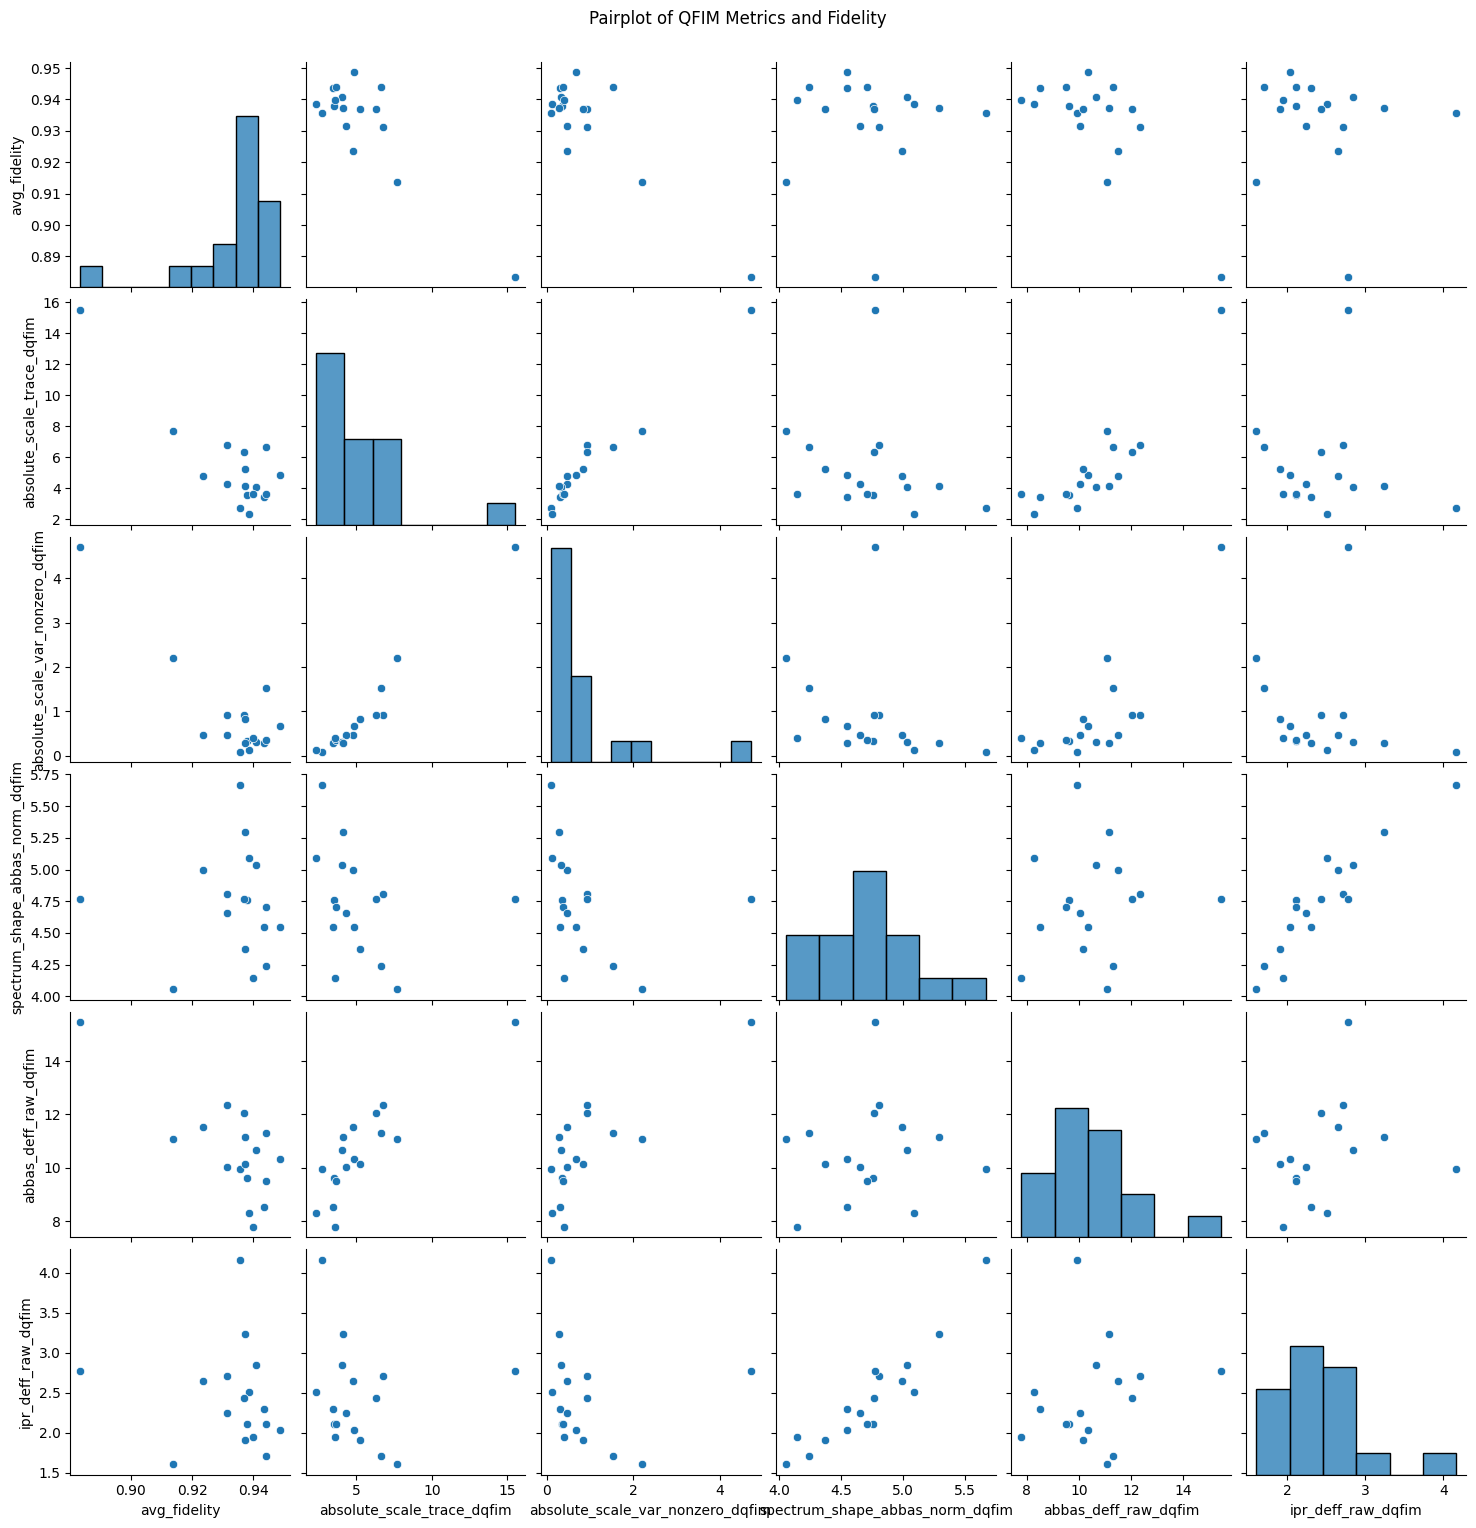

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# Define the list of columns (metrics) you wish to examine.
# Adjust these names if your columns have different names.
metrics_to_plot = [
    'avg_fidelity',         # Averaged fidelity from test results
    'absolute_scale_trace_dqfim',                # Trace of QFIM
   
    'absolute_scale_var_nonzero_dqfim',  # Variance of QFIM eigenvalues (nonzero only)
    
    # 'spread_metric_variance',      
    'spectrum_shape_abbas_norm_dqfim',   
    'abbas_deff_raw_dqfim',   

    'ipr_deff_raw_dqfim',  # Effective dimension computed via the paper's formula
   
]


# 2. Pair Plot
sns.pairplot(df_final[metrics_to_plot])
plt.suptitle("Pairplot of QFIM Metrics and Fidelity", y=1.02)
plt.show()

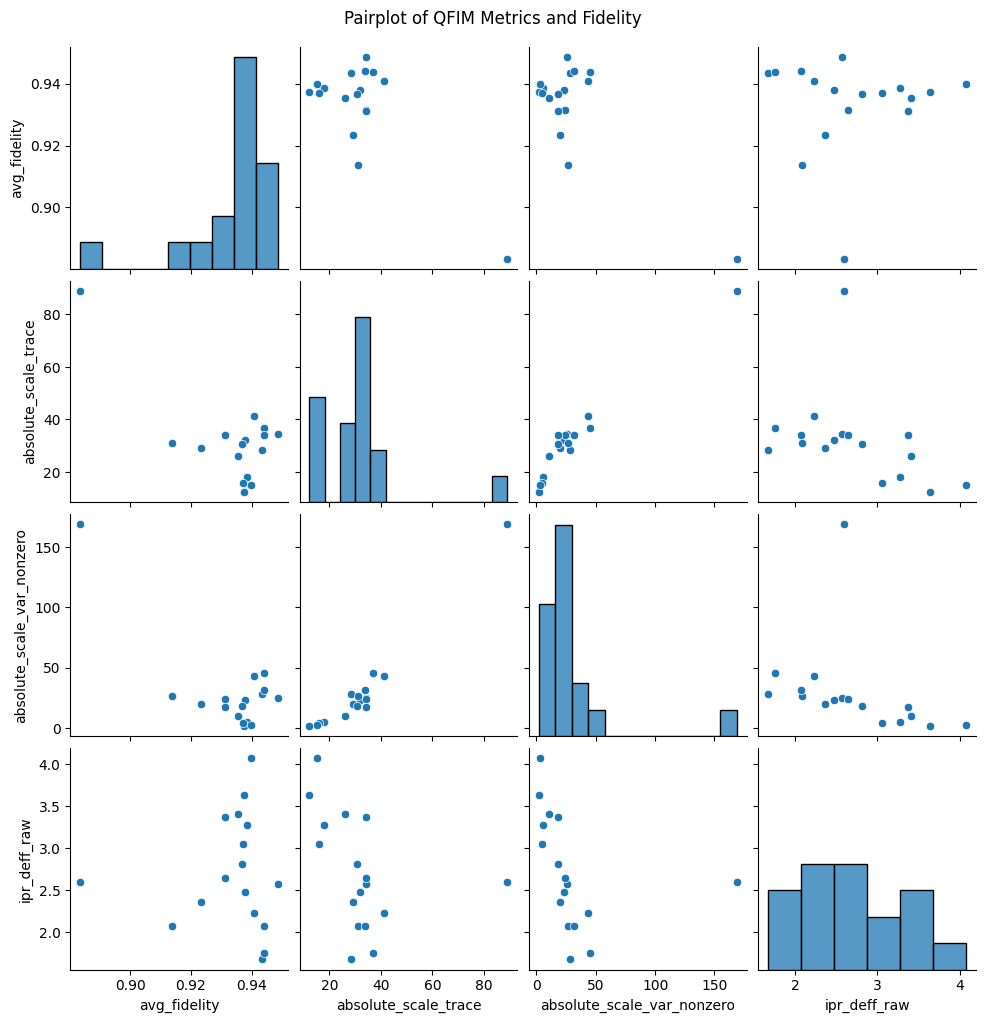

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# Define the list of columns (metrics) you wish to examine.
# Adjust these names if your columns have different names.
metrics_to_plot = [
    'avg_fidelity',         # Averaged fidelity from test results
    'absolute_scale_trace',                # Trace of QFIM
   
    'absolute_scale_var_nonzero',  # Variance of QFIM eigenvalues (nonzero only)
    
    # 'spread_metric_variance',      
    # 'spectrum_shape_ipr_norm',      

    'ipr_deff_raw',  # Effective dimension computed via the paper's formula
    # 'entropy'               # Entropy of the eigenvalue distribution
]


# 2. Pair Plot
sns.pairplot(df_final[metrics_to_plot])
plt.suptitle("Pairplot of QFIM Metrics and Fidelity", y=1.02)
plt.show()

In [14]:
print(df_final.columns)

Index(['test_key', 'fidelities_list', 'avg_fidelity', 'qfim_eigvals',
       'entropy', 'draw_rank', 'absolute_scale_var_all',
       'absolute_scale_var_nonzero', 'absolute_scale_trace', 'ipr_deff_raw',
       'abbas_deff_raw', 'spectrum_shape_ipr_norm',
       'spectrum_shape_abbas_norm', 'spread_metric_variance',
       'spread_metric_mad', 'avg_per_active_mode_var_rank',
       'avg_per_active_mode_trace_rank'],
      dtype='object')


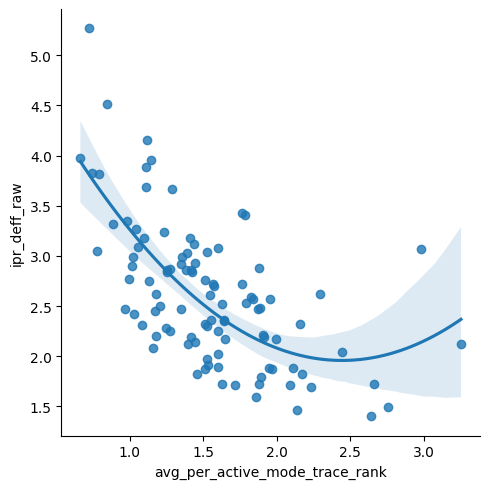

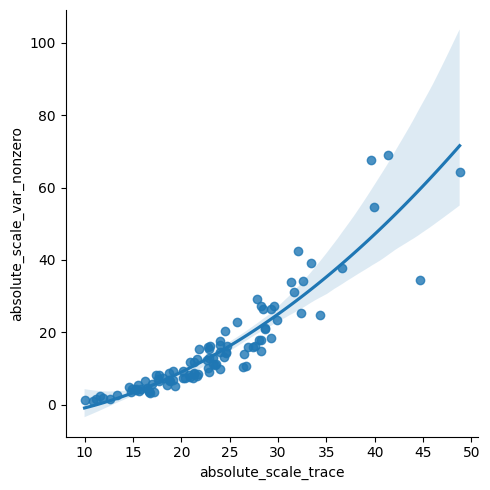

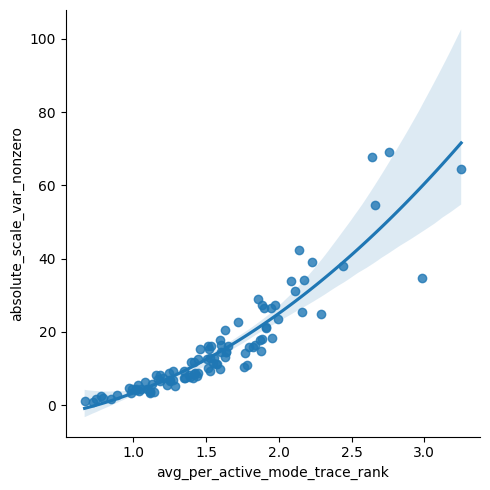

In [10]:
sns.lmplot(x='avg_per_active_mode_trace_rank', y='ipr_deff_raw', data=df_final, order=2)
sns.lmplot(x='absolute_scale_trace', y='absolute_scale_var_nonzero', data=df_final, order=2)
sns.lmplot(x='avg_per_active_mode_trace_rank', y='absolute_scale_var_nonzero', data=df_final, order=2)

In [ ]:
corr_matrix = df_exploded[metrics_to_plot].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of QFIM Metrics and Fidelity")
plt.tight_layout()
plt.show()

In [ ]:
import statsmodels.api as sm

X = df_final[['trace', 'effective_dimension', 'entropy']]  # example
y = df_final['avg_fidelity']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

In [ ]:

# Adjust these names if your columns have different names.
metrics_to_plot = [
    'avg_fidelity',         # Averaged fidelity from test results
    'trace',                # Trace of QFIM
    'var_qfim_eigvals',      # Variance of QFIM eigenvalues (all)
    'var_qfim_eigvals_nonzero',  # Variance of QFIM eigenvalues (nonzero only)
    'var_norm_len',         # Variance normalized by the total number of eigenvalues
    'trace_norm_len',       # Trace normalized by the total number of eigenvalues
    'var_norm_rank',        # Variance normalized by rank
    'trace_norm_rank',      # Trace normalized by rank
    'effective_dimension',  # Effective dimension computed via the paper's formula
    # 'entropy'               # Entropy of the eigenvalue distribution
]
corr_matrix = df_final[metrics_to_plot].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of QFIM Metrics and Fidelity")
plt.tight_layout()
plt.show()


In [ ]:
import os
import pickle
import numpy as np
import os
import pickle
import numpy as np

def read_data_by_gate_new(fixed_param_name, base_path, train_sizes, sample_label='sample_pi', gate_prefix=None):
    """
    Read experiment results from pickle files stored with the following hierarchy:
    
    base_path/
        trainsize_{train_size}/
            {sample_label}/
                {fixed_param_name}/
                    {test_key}/
                        {gate_folder}/
                            data_run_0.pickle
    
    For each test key, the function collects the 'test_results' (converted to fidelities)
    from the pickle file.

    Parameters
    ----------
    fixed_param_name : str
        The fixed parameter folder name (e.g. 'fixed_params0').
    base_path : str
        The base directory containing the experiment results (e.g., 
        "./param_initialization_final/digital_results/Nc_2/reservoirs_1/trotter_10").
    train_sizes : list of int
        A list of training sizes to process (e.g., [10]).
    sample_label : str, optional
        The label of the sample folder (default: "sample_pi").
    gate_prefix : str or None, optional
        If provided, only gate folders that start with this prefix will be processed.
    
    Returns
    -------
    data_by_test_key : dict
        A dictionary mapping each test key to a list of testing results.
    data_by_train_size : dict
        A dictionary mapping each training size to a dictionary (keyed by test key)
        of testing results.
    """
    data_by_test_key = {}
    data_by_train_size = {}

    for train_size in train_sizes:
        # print(f"Processing training size: {train_size}")
        data_by_train_size[train_size] = {}
        data_trainsize = data_by_train_size[train_size]
        
        # Use new folder naming: "trainsize_{train_size}"
        train_folder = f"trainsize_{train_size}"
        train_path = os.path.join(base_path, train_folder, sample_label, fixed_param_name)
        # print(f"Checking train path: {train_path}")
        if not os.path.exists(train_path):
            # print(f"Train path does not exist: {train_path}")
            continue
        
        # Loop over test key folders.
        for test_key in os.listdir(train_path):
            test_key_path = os.path.join(train_path, test_key)
            # print(f"Processing test key: {test_key} at path: {test_key_path}")
            if not os.path.isdir(test_key_path):
                # print(f"Not a directory: {test_key_path}")
                continue
            
            # Loop over gate folders within each test key.
            for gate_folder in sorted(os.listdir(test_key_path)):
                # print(f"Found gate folder: {gate_folder} in test key: {test_key}")
                if gate_prefix is not None and not gate_folder.startswith(gate_prefix):
                    # print(f"Skipping gate folder {gate_folder} because it does not start with {gate_prefix}")
                    continue
                # Construct the full path to the pickle file.
                pickle_file = os.path.join(test_key_path, gate_folder, "data_run_0.pickle")
                # print(f"Looking for pickle file: {pickle_file}")
                if os.path.isfile(pickle_file):
                    try:
                        with open(pickle_file, 'rb') as f:
                            df = pickle.load(f)
                        # print(f"Loaded file {pickle_file} with keys: {list(df.keys())}")
                        if 'costs' in df and 'test_results' in df:
                            try:
                                costs = [float(cost) for cost in df['costs'][0]]
                            except Exception as e:
                                # print(f"Error converting costs in {pickle_file}: {e}")
                                costs = []
                            try:
                                testing_results = [1 - float(res) for res in df['test_results'][0]]
                            except Exception as e:
                                # print(f"Error converting test_results in {pickle_file}: {e}")
                                testing_results = []
                            if test_key not in data_by_test_key:
                                data_by_test_key[test_key] = []
                            if test_key not in data_trainsize:
                                data_trainsize[test_key] = []
                            data_by_test_key[test_key].extend(testing_results)
                            data_trainsize[test_key].extend(testing_results)
                            # print(f"Stored {len(testing_results)} testing results for test key {test_key}")
                        else:
                            print(f"File {pickle_file} missing keys 'costs' or 'test_results'")
                    except Exception as ex:
                        print(f"Error processing {pickle_file}: {ex}")
                else:
                    print(f"Pickle file does not exist: {pickle_file}")
    return data_by_test_key, data_by_train_size

# Example usage:
fixed_param_name = 'fixed_params0'
base_path = "/Users/sophieblock/QRCCapstone/parameter_analysis_directory/param_initialization_final/digital_results/Nc_2/reservoirs_1/trotter_7"
train_sizes = [10,20]
N_ctrl = 2
gate_prefix = f"U{N_ctrl}"  # if you want to only include random gates starting with "U2"
data_by_test_key, data_by_train_size = read_data_by_gate_new(fixed_param_name, base_path, train_sizes, sample_label="sample_pi", gate_prefix=gate_prefix)
# fixed_param_name = 'fixed_params0'
# base_path = "/Users/sophieblock/QRCCapstone/parameter_analysis_directory/param_initialization_final/digital_results/Nc_2/reservoirs_1/trotter_10"
# train_sizes = [10]
# gate_prefix = "U2"  # if you want to only include random gates starting with "U2"
# data_by_test_key, data_by_train_size = read_data_by_gate_new(fixed_param_name, base_path, train_sizes, sample_label="sample_pi", gate_prefix=gate_prefix)

In [ ]:
data_by_test_key['test27']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Function to plot combined KDE of fidelity distributions with average fidelity scores
def plot_combined_kde_fidelity(data_by_test_key, fixed_param_name, include=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.grid(True, zorder=10)
    min_val = np.inf
    # Plot KDE for each test_key with a different color
    plot_results, plot_results_sorted = {}, {}

    # Filter and collect fidelities
    for test_key, fidelities in data_by_test_key.items():
        if include is None or test_key in include:
            temp_min = min(fidelities)
            if temp_min < min_val:
                min_val = temp_min
            plot_results[test_key] = fidelities
            plot_results_sorted[test_key] = np.mean(fidelities)

    # Sort by average fidelities
    plot_results_sorted = sorted(plot_results_sorted.items(), key=lambda x: float(np.mean(x[1])))
    print(plot_results_sorted)

    # Create a colormap based on the number of tests to display
    cmap = plt.get_cmap('rainbow', len(plot_results_sorted))
    
    # Assign colors using the rainbow colormap
    colors = {test_key: cmap(i) for i, (test_key, _) in enumerate(plot_results_sorted)}

    # Plot each test's KDE with the corresponding color
    for i, (test_key, avg_fidelity) in enumerate(plot_results_sorted):
        fidelities = plot_results[test_key]
        sns.kdeplot(fidelities, ax=ax, fill=True, multiple="layer", 
                    color=colors[test_key], label=test_key + f" [$\\bar{{F}} = {round(avg_fidelity,4)}$]")

    # Customize plot
    ax.set_xlabel('Fidelity', fontsize=25)
    # ax.set_xlim(min_val+0.2, 1.05)
    # ax.set_title(f'QFIM Param Init KDE distribution  (50x Random {N_ctrl}-qubit Unitary)', fontsize=28)
    ax.legend(loc='upper left', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)

    plt.tight_layout()
    plt.show()
display =  ['test6','test82','test79','test66','test13','test4']
display = ['test79', 'test47','test46','test32', 'test2','test39','test27','test45','test84']
# plot_combined_kde_fidelity(data_by_train_size[10], fixed_param_name, include=display)
plot_combined_kde_fidelity(data_by_train_size[20], fixed_param_name, include=display)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot combined KDE of fidelity distributions with average fidelity scores
def plot_combined_kde_fidelity(data_by_test_key, fixed_param_name, include=None):
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.grid(True, zorder=10)
    min_val = np.inf
    # Plot KDE for each test_key with a different color
    plot_results, plot_results_sorted = {}, {}

    # Filter and collect fidelities
    for test_key, fidelities in data_by_test_key.items():
        if include is None or test_key in include:
            temp_min = min(fidelities)
            if temp_min < min_val:
                min_val = temp_min
            plot_results[test_key] = fidelities
            plot_results_sorted[test_key] = np.mean(fidelities)

    # Sort by average fidelities
    plot_results_sorted = sorted(plot_results_sorted.items(), key=lambda x: float(np.mean(x[1])))
    print(plot_results_sorted)

    # Create a colormap based on the number of tests to display
    cmap = plt.get_cmap('rainbow', len(plot_results_sorted))
    
    # Assign colors using the rainbow colormap
    colors = {test_key: cmap(i) for i, (test_key, _) in enumerate(plot_results_sorted)}

    # Plot each test's KDE with the corresponding color
    for i, (test_key, avg_fidelity) in enumerate(plot_results_sorted):
        fidelities = plot_results[test_key]
        sns.kdeplot(fidelities, ax=ax, fill=True, multiple="layer", 
                    color=colors[test_key], label=test_key + f" [$\\bar{{F}} = {round(avg_fidelity,4)}$]")

    # Customize plot
    ax.set_xlabel('Fidelity', fontsize=25)
    # ax.set_xlim(min_val+0.2, 1.05)
    ax.set_title(f'QFIM Param Init KDE distribution  (50x Random {N_ctrl}-qubit Unitary)', fontsize=28)
    ax.legend(loc='upper left', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)

    plt.tight_layout()
    plt.show()
display =  ['test18','test89','test172','test73','test35','test196','test139','test15', 'test118','test82','test146','test170' ]
# Example display list and call
# display =['test75', 'test86', 'test44','test5','test141','test133','test130','test190','test141','test165','test66','test58']
# display = ['test110','test20',  'test22', 'test5', 'test67', 'test7','test84','test103']
plot_combined_kde_fidelity(data_trainsize2[10], fixed_param_name, include=display)

In [ ]:
# Function to compute mean and standard deviation for each epoch across all gates for each test key
def compute_cost_statistics(data_by_test_key, epochs_to_show):
    statistics = {}
    for test_key, gates in data_by_test_key.items():
        print(gates)
        mean_costs = []
        std_costs = []
        for epoch in range(epochs_to_show):
            epoch_costs = [costs[epoch] for costs in gates.values() if len(costs) > epoch]
            if epoch_costs:
                mean_costs.append(np.mean(epoch_costs))
                std_costs.append(np.std(epoch_costs))
        statistics[test_key] = (range(len(mean_costs)), mean_costs, std_costs)
    return statistics

# Function to plot cost history with standard deviation for each test key
def plot_cost_history_with_std(data_by_test_key, fixed_param_name, include=None, epochs_to_show=None):
    # Filter test keys based on include argument
    if include is not None:
        data_by_test_key = {k: v for k, v in data_by_test_key.items() if k in include}

    # Determine the number of epochs to show
    if epochs_to_show is None:
        epochs_to_show = min(len(costs) for gates in data_by_test_key.values() for costs in gates.values())

    statistics = compute_cost_statistics(data_by_test_key, epochs_to_show)

    plt.figure(figsize=(10, 6))

    for test_key in include:
        """
        if test_key == 'test56':
            label_str = r"max($Tr(\mathcal{Q})$)"
        elif test_key == 'test3':
            label_str = r"max($Tr(\mathcal{Q})$) 2nd"
        elif test_key == 'test65':
            label_str = r"min($Tr(\mathcal{Q})$) 2nd"

        else:
            label_str = r"min($Tr(\mathcal{Q})$)"
        """
        label_str = test_key
        epochs, mean_costs, std_costs = statistics[test_key]
        plt.plot(epochs, mean_costs, label=label_str)
        plt.fill_between(epochs, np.array(mean_costs) - np.array(std_costs), np.array(mean_costs) + np.array(std_costs), alpha=0.2)

    plt.xlabel('Epochs',fontsize = 20)
    plt.ylabel('Infidelity',fontsize = 20)
    #plt.title(f'Cost History with Standard Deviation for {fixed_param_name}')
    plt.legend()
    plt.tick_params(axis='both', which='major', labelsize=16)  # Make tick labels larger
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# Plot with specific test keys and a limited number of epochs
include_keys = ['test20', 'test22', 'test110','test103', 'test5','test52', 'test116', 'test13', 'test113']
epochs_to_show = 1500

plot_cost_history_with_std(data_by_test_key, fixed_param_name, include=include_keys, epochs_to_show=epochs_to_show)